# Dynamic Hand Gesture Recognition

## Importing

In [1]:
!pip install mediapipe keras tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 19.9 MB/s eta 0:00:00


In [1]:
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from collections import defaultdict
from tqdm import tqdm

import cv2
import numpy as np
import tensorflow as tf
import os
import pickle

from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input

# from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

## Dataset Preprocessing

In [3]:
from huggingface_hub import hf_hub_download

REPO_ID = "Seba213/rgb-dhgr-dataset"

In [4]:
DATASET_NAME = "rgb_blur_split.zip"
dataset = hf_hub_download(repo_id=REPO_ID, filename=DATASET_NAME, repo_type="dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


rgb_blur_split.zip:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

In [ ]:
dataset

'/root/.cache/huggingface/hub/datasets--Seba213--rgb-dhgr-dataset/snapshots/7228096dc1d5f224d474f4dd9e83c9f8b487a0e5/rgb_blur_split.zip'

In [5]:
!sudo unzip /root/.cache/huggingface/hub/datasets--Seba213--rgb-dhgr-dataset/snapshots/7228096dc1d5f224d474f4dd9e83c9f8b487a0e5/rgb_blur_split.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/14.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/28.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/29.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/15.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/17.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/16.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/12.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/13.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/39.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/11.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/10.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/38.png  
 

In [6]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [7]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [4]:
mp_drawing = mp.solutions.drawing_utils

In [54]:
TEST_IMAGE_PATH = "/content/rgb_blur_split/train/scroll_right/2021-10-28-103337_8/12.png"

In [20]:
original_img = cv2.imread(TEST_IMAGE_PATH)
# cv2_imshow(original_img)

# show image with matplotlib
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

NameError: name 'TEST_IMAGE_PATH' is not defined

In [28]:
# For hand landmarks

MARGIN = 30  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54)  # vibrant green

In [5]:
# For pose landmarks

MARGIN = 15  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54)  # vibrant green

In [6]:
def sharpening_image(rgb_image):
  rgb_image = rgb_image.numpy_view()

  # Sharpen the image using the Laplacian operator
  kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

  # Sharpen the image
  sharpened_image = cv2.filter2D(rgb_image, -1, kernel)

  # Convert the sharpened image back to mp.Image
  sharpened_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=sharpened_image)

  return sharpened_image

In [7]:
def draw_pose_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)
  x_coordinates = []
  y_coordinates = []

  # Check if any pose landmarks were detected
  if pose_landmarks_list:
    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
      pose_landmarks = pose_landmarks_list[idx]

      # Draw the pose landmarks.
      pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
      pose_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
      ])
      solutions.drawing_utils.draw_landmarks(
        annotated_image,
        pose_landmarks_proto,
        solutions.pose.POSE_CONNECTIONS,
        solutions.drawing_styles.get_default_pose_landmarks_style())

      # Get the coordinates of all the keypoints
      height, width, _ = annotated_image.shape
      x_coordinates += [int(landmark.x * width) for landmark in pose_landmarks]
      y_coordinates += [int(landmark.y * height) for landmark in pose_landmarks]

    return annotated_image, x_coordinates, y_coordinates
  else:
    # Return default values or handle the case when no landmarks are found
    return rgb_image, [], []  # Return original image and empty lists for x, y

In [8]:
def draw_hand_landmarks_on_image(rgb_image, detection_result):
    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)
    x_coordinates = []
    y_coordinates = []

    # Loop through the detected hands to visualize
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            solutions.hands.HAND_CONNECTIONS,
            solutions.drawing_styles.get_default_hand_landmarks_style(),
            solutions.drawing_styles.get_default_hand_connections_style())

        # Get the coordinates of all the keypoints
        height, width, _ = annotated_image.shape
        x_coordinates += [int(landmark.x * width) for landmark in hand_landmarks]
        y_coordinates += [int(landmark.y * height) for landmark in hand_landmarks]

    return annotated_image, x_coordinates, y_coordinates

In [9]:
def crop(rgb_image, x_coordinates, y_coordinates):

    height, width, _ = rgb_image.shape

    x_min = max(min(x_coordinates) - MARGIN, 0)
    x_max = min(max(x_coordinates) + MARGIN, width)
    y_min = max(min(y_coordinates) - MARGIN, 0)
    y_max = min(max(y_coordinates) + MARGIN, height)

    return rgb_image[y_min:y_max, x_min:x_max]

In [10]:
def cropping_on_pose(image_path):
  base_options = python.BaseOptions(model_asset_path='/Users/sebastianosanson/Development/VCS_Project/pose_landmarker.task')
  options = vision.PoseLandmarkerOptions(base_options=base_options, output_segmentation_masks=True)
  detector = vision.PoseLandmarker.create_from_options(options)

  image = mp.Image.create_from_file(image_path)

  image_np = image.numpy_view()  

  if image_np.shape[-1] == 4:
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2RGB)

  # sharpened_image = sharpening_image(image)

  detection_result = detector.detect(image)

  annotated_image, x, y = draw_pose_landmarks_on_image(image_np, detection_result)

  if not x or not y:
    return None
  else:
    cropped_image = crop(image.numpy_view(), x, y)
    return cropped_image

In [11]:
def cropping_on_hands(image_path):
  base_options = python.BaseOptions(model_asset_path='/Users/sebastianosanson/Development/VCS_Project/hand_landmarker.task')
  options = vision.HandLandmarkerOptions(base_options=base_options,num_hands=2)
  detector = vision.HandLandmarker.create_from_options(options)

  image = mp.Image.create_from_file(image_path)

  # print(image.shape)

  # sharpened_image = sharpening_image(image)

  detection_result = detector.detect(image)

  annotated_image, x, y = draw_hand_landmarks_on_image(image.numpy_view(), detection_result)

  if not x or not y:
    return None
  else:
    cropped_image = crop(image.numpy_view(), x, y)
    return cropped_image

In [12]:
def resize_image(cropped_image):
  image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

  image_resized = cv2.resize(image, (75, 75))

  image_resized = image_resized / 255.0

  image_tensor = tf.convert_to_tensor(image_resized, dtype=tf.float32)

  image_tensor = tf.expand_dims(image_tensor, axis=0)

  return image_tensor

In [13]:
def preprocess_data(image_path):
  # cropped_image = cropping_on_hands(image_path)
  cropped_image = cropping_on_pose(image_path)

  if cropped_image is not None:
    image = resize_image(cropped_image)
    return image
  else:
    return None

In [41]:
# Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# Load the input image.
image = mp.Image.create_from_file(TEST_IMAGE_PATH)

# Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# Process the classification result. In this case, visualize it.
annotated_image, x, y = draw_hand_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

# Display the cropped images
# Assuming 'cropped_images' is a list of images:
cropped_image = crop(image.numpy_view(), x, y)
cv2_imshow(cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))

ValueError: min() arg is an empty sequence

In [70]:
output = cropping_on_pose(TEST_IMAGE_PATH)

cv2_imshow(cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

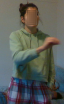

In [64]:
# Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# Load the input image.
image = mp.Image.create_from_file(TEST_IMAGE_PATH)

# Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# Process the detection result. In this case, visualize it.
annotated_image, x, y = draw_pose_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

cropped_image = crop(image.numpy_view(), x, y)
cv2_imshow(cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))

In [65]:
print("Original Image shape:", original_img.shape)

# Load image using OpenCV
image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Print shape
print("Cropped Image shape:", image.shape)

# Resize to (75, 75)
image_resized = cv2.resize(image, (75, 75))

cv2_imshow(cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR))

# Normalize (optional)
image_resized = image_resized / 255.0

# Convert to tensor
image_tensor = tf.convert_to_tensor(image_resized, dtype=tf.float32)

# Add batch dimension if needed
image_tensor = tf.expand_dims(image_tensor, axis=0)

print("Final tensor shape:", image_tensor.shape)

Original Image shape: (120, 160, 3)
Cropped Image shape: (104, 64, 3)


Final tensor shape: (1, 75, 75, 3)


In [14]:
# For splitted dataset

DATASET_PATH = "/Users/sebastianosanson/Development/VCS_Project/rgb_blur_split"

train_dir = os.path.join(DATASET_PATH, "train")

labels = [label for label in os.listdir(train_dir) if not label.startswith('.')]

# Initialize nested dictionary
dataset_dict = defaultdict(lambda: defaultdict(dict))
preprocessed_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

def numerical_sort(file_list):
    return sorted(file_list, key=lambda x: int(os.path.splitext(x)[0]))

# Conta il numero totale di iterazioni per tqdm
total_iterations = sum(
    len(os.listdir(os.path.join(DATASET_PATH, split, class_label)))
    for split in ["train", "val", "test"]
    for class_label in os.listdir(os.path.join(DATASET_PATH, split)) if not class_label.startswith('.')
)

# Usa tqdm per mostrare la progress bar
with tqdm(total=total_iterations, desc="Processing examples") as pbar:
    for split in ["train", "val", "test"]:
        split_path = os.path.join(DATASET_PATH, split)

        class_labels = [label for label in os.listdir(split_path) if not label.startswith('.')]

        for class_label in class_labels:
            class_path = os.path.join(split_path, class_label)

            examples = [example for example in os.listdir(class_path) if not example.startswith('.')]

            for example in examples:
                example_path = os.path.join(class_path, example)

                frame_files = numerical_sort(os.listdir(example_path))
                frame_paths = [os.path.join(example_path, f) for f in frame_files if not f.startswith('.')]

                sampled_frames = frame_paths[::4]

                # Store in dictionary
                dataset_dict[split][class_label][example] = sampled_frames

                for frame_path in sampled_frames:
                    image_tensor = preprocess_data(frame_path)

                    if image_tensor is not None:
                        preprocessed_data[split][class_label][example].append(image_tensor)

                pbar.update(1)  # Aggiorna la progress bar

Processing examples:   0%|          | 0/4189 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1738752068.583004  244941 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1738752068.660300  245560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1738752068.701338  245560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1738752068.795028  245566 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
I0000 00:00:1738752068.827380  244941 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W

KeyboardInterrupt: 

In [23]:
total_examples = 0
for split, class_data in extracted_features.items():
    for class_label, example_data in class_data.items():
        total_examples += len(example_data)

print(f"Total number of examples in dataset_dict: {total_examples}")

Total number of examples in dataset_dict: 4172


In [11]:
total_examples = 0
for split, class_data in loaded_data.items():
    for class_label, example_data in class_data.items():
        total_examples += len(example_data)

print(f"Total number of examples in preprocessed_data: {total_examples}")

Total number of examples in preprocessed_data: 4172


In [12]:
count_10_frames = 0
for split in loaded_data:
    for class_label in loaded_data[split]:
        for example in loaded_data[split][class_label]:
            if len(loaded_data[split][class_label][example]) == 10:
                count_10_frames += 1

print(f"Total number of examples with exactly 10 frames: {count_10_frames}")


Total number of examples with exactly 10 frames: 4155


In [ ]:
# Convert defaultdict to a normal dict
normal_dict = {k: dict(v) for k, v in preprocessed_data.items()}

# Save to a pickle file
with open("preprocessed_data.pkl", "wb") as f:
    pickle.dump(normal_dict, f)

In [ ]:
DATA_NAME = "preprocessed_data.pkl"

preprocessed_data_path = hf_hub_download(repo_id=REPO_ID, filename=DATA_NAME, repo_type="dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessed_data.pkl:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [8]:
preprocessed_data_path = "/Users/sebastianosanson/Development/VCS_Project/pose_preprocessed_data.pkl"

# Load the dictionary back
with open(preprocessed_data_path, "rb") as f:
    loaded_data = pickle.load(f)

In [9]:
def print_preprocessed_data(preprocessed_data):
    """Prints the preprocessed_data dictionary in a structured format."""
    for split, classes in preprocessed_data.items():
        print(f"\n Split: {split.upper()}")
        for class_label, examples in classes.items():
            print(f"  Class: {class_label}")
            for example, frames in examples.items():
                print(f"    Example: {example}")
                print(f"      Frames Processed ({len(frames)}):")
                for idx, frame in enumerate(frames):
                    print(f"        {idx+1}. Tensor Shape: {frame.shape}")  # Print tensor shape

In [21]:
print_preprocessed_data(extracted_features)


 Split: TRAIN
  Class: scroll_left
    Example: 2021-10-17-112714_38
      Frames Processed (10):
        1. Tensor Shape: (1, 1, 2048)
        2. Tensor Shape: (1, 1, 2048)
        3. Tensor Shape: (1, 1, 2048)
        4. Tensor Shape: (1, 1, 2048)
        5. Tensor Shape: (1, 1, 2048)
        6. Tensor Shape: (1, 1, 2048)
        7. Tensor Shape: (1, 1, 2048)
        8. Tensor Shape: (1, 1, 2048)
        9. Tensor Shape: (1, 1, 2048)
        10. Tensor Shape: (1, 1, 2048)
    Example: 2021-10-17-112635_31
      Frames Processed (10):
        1. Tensor Shape: (1, 1, 2048)
        2. Tensor Shape: (1, 1, 2048)
        3. Tensor Shape: (1, 1, 2048)
        4. Tensor Shape: (1, 1, 2048)
        5. Tensor Shape: (1, 1, 2048)
        6. Tensor Shape: (1, 1, 2048)
        7. Tensor Shape: (1, 1, 2048)
        8. Tensor Shape: (1, 1, 2048)
        9. Tensor Shape: (1, 1, 2048)
        10. Tensor Shape: (1, 1, 2048)
    Example: 2021-10-29-203604_3
      Frames Processed (10):
        1. Ten

In [13]:
filtered_data = {}
for split, classes in loaded_data.items():
    filtered_data[split] = {}
    for class_label, examples in classes.items():
        filtered_data[split][class_label] = {}
        for example, frames in examples.items():
            if len(frames) == 10:
                filtered_data[split][class_label][example] = frames

In [15]:
total_examples = 0
for split, class_data in filtered_data.items():
    for class_label, example_data in class_data.items():
        total_examples += len(example_data)

print(f"Total number of examples in preprocessed_data: {total_examples}")

Total number of examples in preprocessed_data: 4155


In [16]:
# Define input shape
INPUT_SHAPE = (75, 75, 3)

# Load pre-trained InceptionV3 without the top classification layers
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
  )

# Extract features from the last convolutional layer
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
# features = feature_extractor.predict(image_tensor)
# print("Feature shape:", features.shape)

# Initialize dictionary to store extracted features
extracted_features = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Count total frames for tqdm progress bar
total_frames = sum(
    len(frames) for split in filtered_data.values()
    for classes in split.values()
    for examples in classes.values()
    for frames in examples
)

In [17]:
def extract_features(frames):
  frame_batch = np.array(frames)
  frame_batch = np.squeeze(frame_batch.astype(np.float32), axis = 1)
  extracted = feature_extractor.predict(frame_batch, verbose=1)
  return extracted

In [18]:
# Extract features with progress tracking
with tqdm(total=total_frames, desc="Extracting features") as pbar:
    for split, classes in loaded_data.items():
        for class_label, examples in classes.items():
            for example, frames in examples.items():

                extracted_features[split][class_label][example] = extract_features(frames)

                pbar.update(1)  # Update progress bar

# Check model summary
feature_extractor.summary()

Extracting features:   0%|          | 0/41550 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   0%|          | 1/41550 [00:01<21:59:33,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 3/41550 [00:02<7:24:53,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:   0%|          | 5/41550 [00:02<4:03:47,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 7/41550 [00:02<2:42:55,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:   0%|          | 9/41550 [00:02<2:01:37,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:   0%|          | 11/41550 [00:02<1:37:44,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:   0%|          | 13/41550 [00:03<1:22:31,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   0%|          | 15/41550 [00:03<1:13:57,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   0%|          | 17/41550 [00:03<1:07:38, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 19/41550 [00:03<1:07:08, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   0%|          | 21/41550 [00:03<1:03:04, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:   0%|          | 23/41550 [00:03<1:00:06, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 25/41550 [00:04<58:19, 11.86it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 27/41550 [00:04<58:28, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 29/41550 [00:04<58:17, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 31/41550 [00:04<57:53, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   0%|          | 33/41550 [00:04<57:14, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   0%|          | 35/41550 [00:04<1:00:27, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   0%|          | 37/41550 [00:05<58:56, 11.74it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   0%|          | 39/41550 [00:05<58:07, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   0%|          | 41/41550 [00:05<57:24, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   0%|          | 43/41550 [00:05<56:24, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   0%|          | 45/41550 [00:05<56:20, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 47/41550 [00:05<56:09, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   0%|          | 49/41550 [00:06<56:03, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   0%|          | 51/41550 [00:06<56:14, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 53/41550 [00:06<1:00:13, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   0%|          | 55/41550 [00:06<59:03, 11.71it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   0%|          | 57/41550 [00:08<3:58:17,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 59/41550 [00:08<3:04:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   0%|          | 61/41550 [00:08<2:26:05,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 63/41550 [00:08<1:59:09,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   0%|          | 65/41550 [00:09<1:39:55,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:   0%|          | 67/41550 [00:09<1:29:42,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   0%|          | 69/41550 [00:09<1:18:46,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 71/41550 [00:09<1:11:12,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 73/41550 [00:09<1:05:53, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 75/41550 [00:09<1:02:44, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   0%|          | 77/41550 [00:10<1:00:05, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   0%|          | 79/41550 [00:10<58:09, 11.89it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 81/41550 [00:10<56:48, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   0%|          | 83/41550 [00:10<56:29, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 85/41550 [00:10<59:24, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 87/41550 [00:10<58:59, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 89/41550 [00:11<58:35, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 91/41550 [00:11<57:49, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 93/41550 [00:11<56:58, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 95/41550 [00:11<57:01, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   0%|          | 97/41550 [00:11<56:50, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   0%|          | 99/41550 [00:11<57:03, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   0%|          | 101/41550 [00:12<57:05, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 103/41550 [00:12<1:00:43, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 105/41550 [00:12<59:55, 11.53it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 107/41550 [00:12<58:58, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 109/41550 [00:12<58:41, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   0%|          | 111/41550 [00:12<58:19, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 113/41550 [00:13<58:28, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 115/41550 [00:13<58:56, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   0%|          | 117/41550 [00:13<58:58, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   0%|          | 119/41550 [00:13<1:01:51, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 121/41550 [00:13<1:00:11, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   0%|          | 123/41550 [00:13<1:00:39, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 125/41550 [00:14<1:00:14, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   0%|          | 127/41550 [00:14<59:18, 11.64it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 129/41550 [00:14<58:23, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 131/41550 [00:14<59:56, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   0%|          | 133/41550 [00:14<59:04, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   0%|          | 135/41550 [00:15<58:15, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 137/41550 [00:15<1:02:40, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   0%|          | 139/41550 [00:15<1:01:44, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 141/41550 [00:15<1:00:30, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 143/41550 [00:15<59:30, 11.60it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 145/41550 [00:15<59:01, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   0%|          | 147/41550 [00:16<59:28, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   0%|          | 149/41550 [00:16<59:53, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 151/41550 [00:16<1:00:05, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   0%|          | 153/41550 [00:16<1:00:13, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   0%|          | 155/41550 [00:16<1:03:17, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   0%|          | 157/41550 [00:16<1:02:45, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   0%|          | 159/41550 [00:17<1:02:31, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   0%|          | 161/41550 [00:17<1:01:52, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 163/41550 [00:17<1:01:03, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   0%|          | 165/41550 [00:17<1:00:53, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 167/41550 [00:17<1:00:26, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 169/41550 [00:18<1:00:34, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   0%|          | 171/41550 [00:18<1:01:31, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   0%|          | 173/41550 [00:18<1:04:41, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   0%|          | 175/41550 [00:18<1:03:21, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   0%|          | 177/41550 [00:18<1:02:39, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   0%|          | 179/41550 [00:18<1:01:09, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 181/41550 [00:19<1:00:11, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   0%|          | 183/41550 [00:19<1:00:11, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   0%|          | 185/41550 [00:19<1:00:12, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   0%|          | 187/41550 [00:19<59:44, 11.54it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   0%|          | 189/41550 [00:19<1:04:12, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 191/41550 [00:20<1:02:38, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 193/41550 [00:20<1:01:47, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   0%|          | 195/41550 [00:20<1:00:49, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   0%|          | 197/41550 [00:20<59:56, 11.50it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   0%|          | 199/41550 [00:20<59:54, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   0%|          | 201/41550 [00:20<1:00:28, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:   0%|          | 203/41550 [00:21<1:01:32, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   0%|          | 205/41550 [00:21<1:00:54, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   0%|          | 207/41550 [00:21<1:04:01, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 209/41550 [00:21<1:03:01, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 211/41550 [00:21<1:02:28, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 213/41550 [00:21<1:01:22, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 215/41550 [00:22<1:01:06, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 217/41550 [00:22<1:00:50, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   1%|          | 219/41550 [00:22<1:02:43, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:   1%|          | 221/41550 [00:22<1:11:37,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 223/41550 [00:22<1:08:08, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 225/41550 [00:23<1:05:52, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   1%|          | 227/41550 [00:23<1:04:52, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|          | 229/41550 [00:23<1:04:03, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 231/41550 [00:23<1:03:14, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|          | 233/41550 [00:23<1:09:07,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 235/41550 [00:24<1:06:59, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 237/41550 [00:24<1:05:07, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 239/41550 [00:24<1:03:21, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 241/41550 [00:24<1:03:16, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|          | 243/41550 [00:24<1:02:32, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 245/41550 [00:24<1:01:52, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 247/41550 [00:25<1:04:41, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 249/41550 [00:25<1:05:53, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 251/41550 [00:25<1:03:33, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 253/41550 [00:25<1:01:52, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 255/41550 [00:25<1:01:23, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   1%|          | 257/41550 [00:26<59:45, 11.52it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 259/41550 [00:26<59:02, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 261/41550 [00:26<59:02, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 263/41550 [00:26<1:02:27, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 265/41550 [00:26<1:01:08, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 267/41550 [00:26<1:00:21, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 269/41550 [00:27<1:00:23, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|          | 271/41550 [00:27<59:39, 11.53it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 273/41550 [00:27<59:10, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   1%|          | 275/41550 [00:27<1:06:42, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 277/41550 [00:27<1:06:31, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   1%|          | 279/41550 [00:28<1:08:21, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 281/41550 [00:28<1:05:19, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 283/41550 [00:28<1:03:38, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|          | 285/41550 [00:28<1:02:01, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 287/41550 [00:28<1:00:46, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 289/41550 [00:28<1:00:06, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 291/41550 [00:29<1:00:00, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 293/41550 [00:29<1:00:32, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 295/41550 [00:29<1:02:20, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 297/41550 [00:29<1:06:12, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 299/41550 [00:29<1:03:54, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 301/41550 [00:30<1:04:52, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 303/41550 [00:30<1:04:47, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 305/41550 [00:30<1:02:52, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 307/41550 [00:30<1:02:17, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:   1%|          | 309/41550 [00:30<1:22:02,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   1%|          | 310/41550 [00:31<1:20:24,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:   1%|          | 311/41550 [00:31<1:28:30,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 312/41550 [00:31<1:29:29,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   1%|          | 314/41550 [00:31<1:21:36,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|          | 315/41550 [00:31<1:19:08,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 317/41550 [00:31<1:14:10,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 319/41550 [00:32<1:09:11,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|          | 321/41550 [00:32<1:08:12, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 323/41550 [00:32<1:10:00,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 325/41550 [00:32<1:06:18, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 327/41550 [00:32<1:09:55,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|          | 329/41550 [00:33<1:07:55, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 331/41550 [00:33<1:05:24, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 333/41550 [00:33<1:03:47, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 335/41550 [00:33<1:02:12, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 337/41550 [00:33<1:01:12, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 339/41550 [00:33<1:01:13, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|          | 341/41550 [00:34<1:00:42, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 343/41550 [00:34<1:04:26, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   1%|          | 345/41550 [00:34<1:05:21, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 347/41550 [00:34<1:04:47, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 349/41550 [00:34<1:03:40, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|          | 351/41550 [00:35<1:02:40, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|          | 353/41550 [00:35<1:02:20, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|          | 355/41550 [00:35<1:04:35, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|          | 357/41550 [00:35<1:02:30, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 359/41550 [00:35<1:05:15, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 361/41550 [00:35<1:04:15, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 363/41550 [00:36<1:03:34, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 365/41550 [00:36<1:04:00, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 367/41550 [00:36<1:03:41, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   1%|          | 369/41550 [00:36<1:04:17, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 371/41550 [00:36<1:02:36, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   1%|          | 373/41550 [00:37<1:01:13, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 375/41550 [00:37<1:04:58, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:   1%|          | 377/41550 [00:37<1:04:26, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 379/41550 [00:37<1:07:17, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 381/41550 [00:37<1:04:46, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 383/41550 [00:38<1:03:44, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   1%|          | 385/41550 [00:38<1:03:04, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 387/41550 [00:38<1:02:54, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 389/41550 [00:38<1:07:16, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 391/41550 [00:38<1:05:04, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 393/41550 [00:38<1:04:25, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 395/41550 [00:39<1:03:14, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 397/41550 [00:39<1:02:36, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 399/41550 [00:39<1:02:16, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 401/41550 [00:39<1:03:15, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|          | 403/41550 [00:39<1:02:46, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|          | 405/41550 [00:40<1:06:37, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   1%|          | 407/41550 [00:40<1:05:16, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:   1%|          | 409/41550 [00:40<1:08:57,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   1%|          | 411/41550 [00:40<1:07:21, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:   1%|          | 413/41550 [00:40<1:11:09,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:   1%|          | 414/41550 [00:41<1:12:07,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:   1%|          | 416/41550 [00:41<1:10:13,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 417/41550 [00:41<1:13:22,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   1%|          | 419/41550 [00:41<1:09:42,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 421/41550 [00:41<1:07:09, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 423/41550 [00:41<1:04:21, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 425/41550 [00:42<1:03:15, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 427/41550 [00:42<1:04:05, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 429/41550 [00:42<1:03:11, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 431/41550 [00:42<1:06:35, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 433/41550 [00:42<1:04:46, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 435/41550 [00:43<1:03:14, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 437/41550 [00:43<1:02:43, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 439/41550 [00:43<1:01:52, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 441/41550 [00:43<1:01:30, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 443/41550 [00:43<1:01:44, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   1%|          | 445/41550 [00:43<1:01:56, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 447/41550 [00:44<1:07:05, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 449/41550 [00:44<1:05:35, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 451/41550 [00:44<1:03:19, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   1%|          | 453/41550 [00:44<1:12:39,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|          | 454/41550 [00:44<1:13:26,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 456/41550 [00:45<1:10:05,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 458/41550 [00:45<1:07:33, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 460/41550 [00:45<1:10:26,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 462/41550 [00:45<1:07:06, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 464/41550 [00:45<1:04:47, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:   1%|          | 466/41550 [00:46<1:04:03, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 468/41550 [00:46<1:02:43, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|          | 470/41550 [00:46<1:02:41, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 472/41550 [00:46<1:01:45, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 474/41550 [00:46<1:01:22, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 476/41550 [00:46<1:04:49, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 478/41550 [00:47<1:03:17, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 480/41550 [00:47<1:03:20, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 482/41550 [00:47<1:02:41, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 484/41550 [00:47<1:02:01, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|          | 486/41550 [00:47<1:02:13, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 488/41550 [00:48<1:02:27, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 490/41550 [00:48<1:06:20, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 492/41550 [00:48<1:05:01, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 494/41550 [00:48<1:03:32, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 496/41550 [00:48<1:01:37, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   1%|          | 498/41550 [00:48<1:00:41, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 500/41550 [00:49<59:18, 11.54it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|          | 502/41550 [00:49<58:05, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|          | 504/41550 [00:49<56:56, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 506/41550 [00:49<56:29, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 508/41550 [00:49<58:15, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|          | 510/41550 [00:49<57:33, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 512/41550 [00:50<57:19, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 514/41550 [00:50<1:01:15, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|          | 516/41550 [00:50<1:00:02, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|          | 518/41550 [00:50<59:19, 11.53it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|▏         | 520/41550 [00:50<57:53, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|▏         | 522/41550 [00:50<57:10, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|▏         | 524/41550 [00:51<56:40, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|▏         | 526/41550 [00:51<57:49, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|▏         | 528/41550 [00:51<57:30, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|▏         | 530/41550 [00:51<57:47, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|▏         | 532/41550 [00:51<58:04, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 534/41550 [00:52<1:00:37, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 536/41550 [00:52<58:47, 11.63it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|▏         | 538/41550 [00:52<57:52, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|▏         | 540/41550 [00:52<57:25, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|▏         | 542/41550 [00:52<57:49, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 544/41550 [00:52<57:16, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|▏         | 546/41550 [00:52<56:01, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 548/41550 [00:53<55:56, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|▏         | 550/41550 [00:53<55:40, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|▏         | 552/41550 [00:53<58:50, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|▏         | 554/41550 [00:53<57:50, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 556/41550 [00:53<56:57, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|▏         | 558/41550 [00:53<56:25, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|▏         | 560/41550 [00:54<56:26, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|▏         | 562/41550 [00:54<55:50, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|▏         | 564/41550 [00:54<56:17, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   1%|▏         | 566/41550 [00:54<58:09, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|▏         | 568/41550 [00:54<57:09, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 570/41550 [00:55<1:00:32, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 572/41550 [00:55<58:56, 11.59it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 574/41550 [00:55<57:48, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|▏         | 576/41550 [00:55<56:34, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|▏         | 578/41550 [00:55<56:26, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 580/41550 [00:55<55:47, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 582/41550 [00:55<55:14, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|▏         | 584/41550 [00:56<54:58, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 586/41550 [00:56<54:35, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   1%|▏         | 588/41550 [00:56<57:27, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|▏         | 590/41550 [00:56<56:30, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 592/41550 [00:56<55:44, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|▏         | 594/41550 [00:56<55:16, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|▏         | 596/41550 [00:57<55:06, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 598/41550 [00:57<54:42, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 600/41550 [00:57<54:31, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|▏         | 602/41550 [00:57<54:53, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|▏         | 604/41550 [00:57<54:41, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 606/41550 [00:57<58:03, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 608/41550 [00:58<56:57, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|▏         | 610/41550 [00:58<56:19, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   1%|▏         | 612/41550 [00:58<56:08, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   1%|▏         | 614/41550 [00:58<56:08, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|▏         | 616/41550 [00:58<55:48, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   1%|▏         | 618/41550 [00:58<55:51, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   1%|▏         | 620/41550 [00:59<55:59, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   1%|▏         | 622/41550 [00:59<55:35, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 624/41550 [00:59<58:50, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   2%|▏         | 626/41550 [00:59<58:16, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 628/41550 [00:59<57:36, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 630/41550 [00:59<56:44, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 632/41550 [01:00<56:29, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 634/41550 [01:00<55:52, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 636/41550 [01:00<55:41, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 638/41550 [01:00<55:17, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 640/41550 [01:00<55:24, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 642/41550 [01:00<59:15, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 644/41550 [01:01<57:58, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 646/41550 [01:01<56:42, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   2%|▏         | 648/41550 [01:01<56:11, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   2%|▏         | 650/41550 [01:01<56:02, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 652/41550 [01:01<55:48, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 654/41550 [01:01<55:31, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 656/41550 [01:02<55:47, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 658/41550 [01:02<58:45, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 660/41550 [01:02<1:01:56, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   2%|▏         | 662/41550 [01:02<1:00:17, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 664/41550 [01:02<58:47, 11.59it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 666/41550 [01:02<57:55, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 668/41550 [01:03<58:16, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 670/41550 [01:03<57:25, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 672/41550 [01:03<56:45, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   2%|▏         | 674/41550 [01:03<56:55, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 676/41550 [01:03<1:00:15, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 678/41550 [01:04<58:56, 11.56it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 680/41550 [01:04<58:13, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 682/41550 [01:04<58:49, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 684/41550 [01:04<57:24, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 686/41550 [01:04<56:54, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 688/41550 [01:04<57:10, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   2%|▏         | 690/41550 [01:05<57:10, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 692/41550 [01:05<58:06, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 694/41550 [01:05<1:01:23, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 696/41550 [01:05<59:38, 11.42it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 698/41550 [01:05<58:14, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 700/41550 [01:05<56:55, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 702/41550 [01:06<56:02, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 704/41550 [01:06<55:04, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 706/41550 [01:06<55:02, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 708/41550 [01:06<54:24, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 710/41550 [01:06<57:50, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 712/41550 [01:06<57:09, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   2%|▏         | 714/41550 [01:07<57:05, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 716/41550 [01:07<56:06, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 718/41550 [01:07<55:27, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 720/41550 [01:07<54:52, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 722/41550 [01:07<54:30, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 724/41550 [01:07<54:18, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 726/41550 [01:07<54:23, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 728/41550 [01:08<58:06, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 730/41550 [01:08<57:10, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 732/41550 [01:08<56:08, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 734/41550 [01:08<55:26, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 736/41550 [01:08<55:00, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 738/41550 [01:08<54:36, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 740/41550 [01:09<54:27, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 742/41550 [01:09<54:21, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 744/41550 [01:09<57:45, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 746/41550 [01:09<56:40, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 748/41550 [01:09<55:44, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 750/41550 [01:09<54:52, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 752/41550 [01:10<55:00, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 754/41550 [01:10<54:41, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 756/41550 [01:10<54:25, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 758/41550 [01:10<55:06, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 760/41550 [01:10<58:15, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 762/41550 [01:10<56:51, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 764/41550 [01:11<55:45, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 766/41550 [01:11<54:52, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 768/41550 [01:11<54:28, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 770/41550 [01:11<54:04, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 772/41550 [01:11<53:50, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 774/41550 [01:11<53:58, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 776/41550 [01:12<54:05, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 778/41550 [01:12<57:34, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 780/41550 [01:12<56:25, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 782/41550 [01:12<55:51, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 784/41550 [01:12<55:28, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 786/41550 [01:12<54:57, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 788/41550 [01:13<54:29, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 790/41550 [01:13<54:38, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 792/41550 [01:13<55:00, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 794/41550 [01:13<58:44, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 796/41550 [01:13<57:32, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 798/41550 [01:13<56:45, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 800/41550 [01:14<55:58, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 802/41550 [01:14<55:43, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 804/41550 [01:14<55:14, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 806/41550 [01:14<55:06, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:   2%|▏         | 808/41550 [01:14<58:08, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 810/41550 [01:14<56:46, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 812/41550 [01:15<56:10, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 814/41550 [01:15<55:37, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 816/41550 [01:15<55:22, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 818/41550 [01:15<55:20, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 820/41550 [01:15<54:26, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 822/41550 [01:15<54:20, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 824/41550 [01:16<57:40, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 826/41550 [01:16<56:28, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 828/41550 [01:16<55:39, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 830/41550 [01:16<55:03, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 832/41550 [01:16<54:37, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 834/41550 [01:16<54:26, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 836/41550 [01:16<54:14, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 838/41550 [01:17<54:26, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 840/41550 [01:17<58:03, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 842/41550 [01:17<57:01, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 844/41550 [01:17<56:33, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 846/41550 [01:17<55:47, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   2%|▏         | 848/41550 [01:17<56:02, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 850/41550 [01:18<55:45, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 852/41550 [01:18<55:31, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 854/41550 [01:18<54:59, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 856/41550 [01:18<57:55, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 858/41550 [01:18<57:02, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 860/41550 [01:18<55:44, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 862/41550 [01:19<54:53, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 864/41550 [01:19<54:33, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 866/41550 [01:19<54:29, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 868/41550 [01:19<54:33, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 870/41550 [01:19<54:30, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 872/41550 [01:19<57:35, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 874/41550 [01:20<56:27, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 876/41550 [01:20<56:01, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 878/41550 [01:20<55:41, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 880/41550 [01:20<55:17, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 882/41550 [01:20<55:06, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 884/41550 [01:20<54:56, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 886/41550 [01:21<57:51, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 888/41550 [01:21<56:29, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 890/41550 [01:21<55:37, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 892/41550 [01:21<55:04, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 894/41550 [01:21<54:33, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 896/41550 [01:21<54:23, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 898/41550 [01:22<54:57, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 900/41550 [01:22<59:16, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 902/41550 [01:22<58:06, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 904/41550 [01:22<56:44, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 906/41550 [01:22<55:49, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 908/41550 [01:22<55:11, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 910/41550 [01:23<54:35, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 912/41550 [01:23<54:31, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:   2%|▏         | 914/41550 [01:23<57:20, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 916/41550 [01:23<56:17, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 918/41550 [01:23<55:35, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 920/41550 [01:23<55:24, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 922/41550 [01:24<54:45, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 924/41550 [01:24<54:04, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 926/41550 [01:24<54:21, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 928/41550 [01:24<57:33, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 930/41550 [01:24<56:25, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 932/41550 [01:24<55:17, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 934/41550 [01:25<55:12, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 936/41550 [01:25<54:56, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 938/41550 [01:25<54:40, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 940/41550 [01:25<54:37, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 942/41550 [01:25<58:13, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 944/41550 [01:25<57:09, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 946/41550 [01:26<55:59, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 948/41550 [01:26<55:04, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 950/41550 [01:26<54:29, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 952/41550 [01:26<54:20, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 954/41550 [01:26<53:52, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 956/41550 [01:26<57:08, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 958/41550 [01:27<55:57, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 960/41550 [01:27<55:27, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 962/41550 [01:27<55:04, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 964/41550 [01:27<54:39, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 966/41550 [01:27<54:28, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 968/41550 [01:27<54:15, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 970/41550 [01:28<58:13, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 972/41550 [01:28<57:15, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 974/41550 [01:28<56:56, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 976/41550 [01:28<56:18, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 978/41550 [01:28<55:34, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 980/41550 [01:28<54:53, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 982/41550 [01:28<54:19, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 984/41550 [01:29<57:33, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 986/41550 [01:29<56:34, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 988/41550 [01:29<56:18, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 990/41550 [01:29<55:25, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 992/41550 [01:29<54:56, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 994/41550 [01:29<54:39, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 996/41550 [01:30<54:35, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:   2%|▏         | 998/41550 [01:30<58:01, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 1000/41550 [01:30<56:43, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 1002/41550 [01:30<56:03, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 1004/41550 [01:30<55:41, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 1006/41550 [01:30<55:28, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 1008/41550 [01:31<54:51, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 1010/41550 [01:31<54:38, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 1012/41550 [01:31<58:10, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 1014/41550 [01:31<56:49, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 1016/41550 [01:31<56:30, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 1018/41550 [01:31<56:02, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 1020/41550 [01:32<55:27, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   2%|▏         | 1022/41550 [01:32<55:19, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 1024/41550 [01:32<58:57, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   2%|▏         | 1026/41550 [01:32<57:56, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   2%|▏         | 1028/41550 [01:32<56:51, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 1030/41550 [01:32<55:49, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 1032/41550 [01:33<55:01, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 1034/41550 [01:33<54:33, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 1036/41550 [01:33<54:04, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   2%|▏         | 1038/41550 [01:33<57:32, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1040/41550 [01:33<56:18, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1042/41550 [01:33<55:40, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1044/41550 [01:34<54:58, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1046/41550 [01:34<54:58, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1048/41550 [01:34<54:20, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1050/41550 [01:34<54:39, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1052/41550 [01:34<58:07, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1054/41550 [01:34<57:22, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1056/41550 [01:35<56:19, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1058/41550 [01:35<56:21, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1060/41550 [01:35<55:48, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1062/41550 [01:35<55:16, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1064/41550 [01:35<55:21, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1066/41550 [01:35<58:44, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1068/41550 [01:36<57:10, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1070/41550 [01:36<56:10, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1072/41550 [01:36<55:36, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1074/41550 [01:36<55:39, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1076/41550 [01:36<55:08, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1078/41550 [01:36<54:37, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1080/41550 [01:37<57:44, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1082/41550 [01:37<57:10, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1084/41550 [01:37<56:23, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1086/41550 [01:37<55:50, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1088/41550 [01:37<55:09, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1090/41550 [01:37<54:36, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   3%|▎         | 1092/41550 [01:38<54:26, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1094/41550 [01:38<57:46, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1096/41550 [01:38<56:54, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1098/41550 [01:38<56:07, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1100/41550 [01:38<55:16, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1102/41550 [01:38<55:04, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1104/41550 [01:39<54:50, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1106/41550 [01:39<57:50, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1108/41550 [01:39<56:50, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1110/41550 [01:39<55:36, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1112/41550 [01:39<55:09, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1114/41550 [01:39<54:46, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1116/41550 [01:40<54:16, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1118/41550 [01:40<54:20, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1120/41550 [01:40<57:42, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1122/41550 [01:40<56:49, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1124/41550 [01:40<56:03, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1126/41550 [01:40<55:28, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1128/41550 [01:41<55:05, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1130/41550 [01:41<55:24, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1132/41550 [01:41<58:19, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   3%|▎         | 1134/41550 [01:41<57:41, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1136/41550 [01:41<57:03, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1138/41550 [01:41<56:00, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1140/41550 [01:42<55:41, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1142/41550 [01:42<55:36, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1144/41550 [01:42<58:55, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1146/41550 [01:42<57:53, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1148/41550 [01:42<56:55, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1150/41550 [01:42<56:22, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1152/41550 [01:43<55:48, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1154/41550 [01:43<55:26, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1156/41550 [01:43<58:35, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1158/41550 [01:43<57:12, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1160/41550 [01:43<56:18, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1162/41550 [01:43<55:29, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1164/41550 [01:44<54:54, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1166/41550 [01:44<54:49, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:   3%|▎         | 1168/41550 [01:44<57:53, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1170/41550 [01:44<57:16, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1172/41550 [01:44<56:29, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   3%|▎         | 1174/41550 [01:44<55:31, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1176/41550 [01:45<55:09, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1178/41550 [01:45<55:11, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1180/41550 [01:45<58:23, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1182/41550 [01:45<57:05, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1184/41550 [01:45<56:19, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1186/41550 [01:45<55:43, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1188/41550 [01:46<54:59, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1190/41550 [01:46<55:03, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1192/41550 [01:46<54:38, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1194/41550 [01:46<57:52, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1196/41550 [01:46<56:18, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1198/41550 [01:46<55:34, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1200/41550 [01:47<55:31, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1202/41550 [01:47<55:01, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1204/41550 [01:47<54:40, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1206/41550 [01:47<58:34, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1208/41550 [01:47<57:53, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1210/41550 [01:47<56:40, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1212/41550 [01:48<55:36, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1214/41550 [01:48<55:18, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1216/41550 [01:48<54:51, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1218/41550 [01:48<58:07, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1220/41550 [01:48<56:53, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1222/41550 [01:48<56:20, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1224/41550 [01:49<55:49, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1226/41550 [01:49<55:15, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1228/41550 [01:49<54:59, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:   3%|▎         | 1230/41550 [01:49<58:03, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1232/41550 [01:49<56:48, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1234/41550 [01:49<55:42, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1236/41550 [01:50<55:29, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1238/41550 [01:50<54:58, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1240/41550 [01:50<55:03, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1242/41550 [01:50<59:04, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   3%|▎         | 1244/41550 [01:50<57:44, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1246/41550 [01:51<56:57, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1248/41550 [01:51<55:47, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1250/41550 [01:51<55:26, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1252/41550 [01:51<54:54, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1254/41550 [01:51<58:20, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1256/41550 [01:51<57:29, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1258/41550 [01:52<56:13, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1260/41550 [01:52<55:39, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1262/41550 [01:52<55:43, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1264/41550 [01:52<59:02, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1266/41550 [01:52<57:27, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1268/41550 [01:52<56:33, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1270/41550 [01:53<56:17, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1272/41550 [01:53<55:42, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1274/41550 [01:53<55:41, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1276/41550 [01:53<58:47, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1278/41550 [01:53<57:48, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1280/41550 [01:53<56:42, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1282/41550 [01:54<56:03, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1284/41550 [01:54<55:33, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1286/41550 [01:54<55:00, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1288/41550 [01:54<58:53, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1290/41550 [01:54<57:30, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1292/41550 [01:54<56:40, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1294/41550 [01:55<56:07, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1296/41550 [01:55<55:09, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1298/41550 [01:55<55:04, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1300/41550 [01:55<57:59, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1302/41550 [01:55<56:22, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1304/41550 [01:55<55:12, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1306/41550 [01:56<54:34, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1308/41550 [01:56<54:10, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1310/41550 [01:56<54:08, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1312/41550 [01:56<57:50, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1314/41550 [01:56<56:18, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1316/41550 [01:56<55:19, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1318/41550 [01:57<54:50, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1320/41550 [01:57<54:18, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:   3%|▎         | 1322/41550 [01:57<57:38, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1324/41550 [01:57<56:15, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1326/41550 [01:57<55:33, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1328/41550 [01:57<54:30, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1330/41550 [01:58<54:11, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1332/41550 [01:58<54:09, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1334/41550 [01:58<57:22, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1336/41550 [01:58<56:21, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1338/41550 [01:58<55:22, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1340/41550 [01:58<55:09, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1342/41550 [01:59<55:19, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1344/41550 [01:59<54:57, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1346/41550 [01:59<58:20, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1348/41550 [01:59<56:54, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1350/41550 [01:59<56:19, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1352/41550 [01:59<55:51, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1354/41550 [02:00<56:49, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1356/41550 [02:00<55:36, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   3%|▎         | 1358/41550 [02:00<59:50, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1360/41550 [02:00<59:12, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1362/41550 [02:00<58:08, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   3%|▎         | 1364/41550 [02:00<59:51, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:   3%|▎         | 1366/41550 [02:01<1:04:37, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   3%|▎         | 1368/41550 [02:01<1:08:26,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:   3%|▎         | 1369/41550 [02:01<1:09:08,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting features:   3%|▎         | 1370/41550 [02:01<1:12:23,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   3%|▎         | 1371/41550 [02:01<1:18:21,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1373/41550 [02:01<1:10:36,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1375/41550 [02:02<1:05:26, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:   3%|▎         | 1377/41550 [02:02<1:06:12, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1379/41550 [02:02<1:04:12, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   3%|▎         | 1381/41550 [02:02<1:02:21, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1383/41550 [02:02<1:05:32, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   3%|▎         | 1385/41550 [02:03<1:02:59, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1387/41550 [02:03<1:00:11, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1389/41550 [02:03<58:00, 11.54it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1391/41550 [02:03<56:43, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1393/41550 [02:03<55:52, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1395/41550 [02:03<59:47, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   3%|▎         | 1397/41550 [02:04<57:47, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   3%|▎         | 1399/41550 [02:04<57:28, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1401/41550 [02:04<56:34, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1403/41550 [02:04<57:00, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   3%|▎         | 1405/41550 [02:04<1:03:17, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1407/41550 [02:04<1:01:27, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1409/41550 [02:05<1:00:00, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1411/41550 [02:05<58:57, 11.35it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1413/41550 [02:05<57:42, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1415/41550 [02:05<56:41, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1417/41550 [02:05<59:45, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1419/41550 [02:06<58:00, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1421/41550 [02:06<57:28, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1423/41550 [02:06<56:53, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   3%|▎         | 1425/41550 [02:06<56:30, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1427/41550 [02:06<1:00:33, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   3%|▎         | 1429/41550 [02:06<1:00:28, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   3%|▎         | 1431/41550 [02:07<58:59, 11.33it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1433/41550 [02:07<57:31, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1435/41550 [02:07<56:45, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1437/41550 [02:07<1:03:28, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1439/41550 [02:07<1:00:37, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1441/41550 [02:07<58:57, 11.34it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1443/41550 [02:08<57:37, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:   3%|▎         | 1445/41550 [02:08<57:47, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1447/41550 [02:08<1:00:49, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 1449/41550 [02:08<58:47, 11.37it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   3%|▎         | 1451/41550 [02:08<57:08, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:   3%|▎         | 1453/41550 [02:09<58:07, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   4%|▎         | 1455/41550 [02:09<1:00:09, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   4%|▎         | 1457/41550 [02:09<59:43, 11.19it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   4%|▎         | 1459/41550 [02:09<1:15:21,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   4%|▎         | 1461/41550 [02:09<1:10:16,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▎         | 1463/41550 [02:10<1:06:52,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1465/41550 [02:10<1:03:29, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▎         | 1467/41550 [02:10<1:00:58, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1469/41550 [02:10<58:54, 11.34it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1471/41550 [02:10<57:25, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▎         | 1473/41550 [02:10<59:47, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1475/41550 [02:11<58:10, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▎         | 1477/41550 [02:11<57:23, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   4%|▎         | 1479/41550 [02:11<58:05, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▎         | 1481/41550 [02:11<57:24, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▎         | 1483/41550 [02:11<1:00:17, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▎         | 1485/41550 [02:11<58:31, 11.41it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1487/41550 [02:12<57:03, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▎         | 1489/41550 [02:12<56:27, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1491/41550 [02:12<55:57, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▎         | 1493/41550 [02:12<59:34, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▎         | 1495/41550 [02:12<58:18, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1497/41550 [02:12<56:39, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   4%|▎         | 1499/41550 [02:13<57:25, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   4%|▎         | 1501/41550 [02:13<59:02, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1503/41550 [02:13<1:03:12, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   4%|▎         | 1505/41550 [02:13<1:01:49, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1507/41550 [02:13<1:01:14, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1509/41550 [02:14<59:02, 11.30it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1511/41550 [02:14<58:14, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   4%|▎         | 1513/41550 [02:14<1:01:54, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▎         | 1515/41550 [02:14<1:00:43, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   4%|▎         | 1517/41550 [02:14<59:05, 11.29it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   4%|▎         | 1519/41550 [02:14<59:24, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▎         | 1521/41550 [02:15<58:46, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▎         | 1523/41550 [02:15<57:49, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1525/41550 [02:15<1:00:15, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1527/41550 [02:15<58:04, 11.49it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▎         | 1529/41550 [02:15<57:11, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▎         | 1531/41550 [02:15<56:38, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1533/41550 [02:16<55:30, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▎         | 1535/41550 [02:16<58:16, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▎         | 1537/41550 [02:16<57:03, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▎         | 1539/41550 [02:16<56:17, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▎         | 1541/41550 [02:16<54:44, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▎         | 1543/41550 [02:16<54:29, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▎         | 1545/41550 [02:17<57:36, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▎         | 1547/41550 [02:17<56:29, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▎         | 1549/41550 [02:17<56:47, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   4%|▎         | 1551/41550 [02:17<56:59, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▎         | 1553/41550 [02:17<56:32, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   4%|▎         | 1555/41550 [02:18<56:46, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   4%|▎         | 1557/41550 [02:18<1:00:54, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   4%|▍         | 1559/41550 [02:18<59:26, 11.21it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1561/41550 [02:18<59:32, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1563/41550 [02:18<57:57, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1565/41550 [02:18<56:42, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1567/41550 [02:19<55:50, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1569/41550 [02:19<58:47, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1571/41550 [02:19<57:00, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1573/41550 [02:19<56:07, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1575/41550 [02:19<55:08, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1577/41550 [02:19<54:26, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1579/41550 [02:20<57:44, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1581/41550 [02:20<56:17, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1583/41550 [02:20<55:19, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1585/41550 [02:20<54:50, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1587/41550 [02:20<54:21, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1589/41550 [02:20<57:36, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1591/41550 [02:21<56:24, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1593/41550 [02:21<55:19, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1595/41550 [02:21<54:32, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1597/41550 [02:21<54:16, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   4%|▍         | 1599/41550 [02:21<58:39, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   4%|▍         | 1601/41550 [02:21<58:24, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   4%|▍         | 1603/41550 [02:22<57:48, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1605/41550 [02:22<57:08, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1607/41550 [02:22<56:23, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▍         | 1609/41550 [02:22<56:25, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1611/41550 [02:22<1:01:07, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1613/41550 [02:23<59:21, 11.21it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1615/41550 [02:23<57:57, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1617/41550 [02:23<56:36, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1619/41550 [02:23<55:33, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1621/41550 [02:23<58:29, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1623/41550 [02:23<57:17, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1625/41550 [02:24<56:17, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1627/41550 [02:24<55:28, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1629/41550 [02:24<54:54, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1631/41550 [02:24<58:16, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1633/41550 [02:24<56:38, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1635/41550 [02:24<55:44, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1637/41550 [02:25<55:19, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1639/41550 [02:25<54:52, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:   4%|▍         | 1641/41550 [02:25<1:00:27, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1643/41550 [02:25<1:00:17, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1645/41550 [02:25<58:47, 11.31it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1647/41550 [02:25<57:09, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:   4%|▍         | 1649/41550 [02:26<59:45, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1651/41550 [02:26<58:03, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1653/41550 [02:26<56:42, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1655/41550 [02:26<55:36, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1657/41550 [02:26<54:44, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1659/41550 [02:26<57:46, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1661/41550 [02:27<56:18, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1663/41550 [02:27<55:19, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1665/41550 [02:27<54:39, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:   4%|▍         | 1667/41550 [02:27<57:38, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1669/41550 [02:27<56:24, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1671/41550 [02:27<55:25, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1673/41550 [02:28<54:44, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1675/41550 [02:28<54:13, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1677/41550 [02:28<57:17, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1679/41550 [02:28<56:16, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1681/41550 [02:28<55:18, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1683/41550 [02:28<54:54, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   4%|▍         | 1685/41550 [02:29<54:03, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   4%|▍         | 1687/41550 [02:29<58:23, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   4%|▍         | 1689/41550 [02:29<57:51, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▍         | 1691/41550 [02:29<57:58, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▍         | 1693/41550 [02:29<57:24, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   4%|▍         | 1695/41550 [02:30<1:01:22, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   4%|▍         | 1697/41550 [02:30<59:55, 11.08it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1699/41550 [02:30<58:41, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1701/41550 [02:30<56:44, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1703/41550 [02:30<55:48, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1705/41550 [02:30<58:38, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1707/41550 [02:31<57:09, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1709/41550 [02:31<56:14, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1711/41550 [02:31<55:31, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:   4%|▍         | 1713/41550 [02:31<57:26, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1715/41550 [02:31<56:04, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1717/41550 [02:31<54:58, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1719/41550 [02:32<54:30, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1721/41550 [02:32<53:22, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1723/41550 [02:32<57:15, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1725/41550 [02:32<56:15, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1727/41550 [02:32<55:19, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1729/41550 [02:32<54:28, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1731/41550 [02:33<57:31, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1733/41550 [02:33<56:13, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1735/41550 [02:33<55:24, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1737/41550 [02:33<54:28, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1739/41550 [02:33<53:52, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1741/41550 [02:33<57:09, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1743/41550 [02:34<55:56, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1745/41550 [02:34<55:10, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1747/41550 [02:34<54:49, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1749/41550 [02:34<54:04, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1751/41550 [02:34<57:05, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1753/41550 [02:34<56:00, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1755/41550 [02:35<55:28, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1757/41550 [02:35<54:59, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1759/41550 [02:35<57:57, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1761/41550 [02:35<56:25, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1763/41550 [02:35<55:28, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1765/41550 [02:35<54:33, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1767/41550 [02:36<54:33, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1769/41550 [02:36<57:54, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1771/41550 [02:36<56:31, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1773/41550 [02:36<55:28, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1775/41550 [02:36<54:40, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   4%|▍         | 1777/41550 [02:36<54:10, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1779/41550 [02:37<57:14, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1781/41550 [02:37<56:15, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1783/41550 [02:37<55:12, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1785/41550 [02:37<54:20, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1787/41550 [02:37<57:35, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1789/41550 [02:37<56:01, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1791/41550 [02:38<55:12, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1793/41550 [02:38<54:46, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1795/41550 [02:38<54:03, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1797/41550 [02:38<57:30, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1799/41550 [02:38<56:08, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1801/41550 [02:38<55:02, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1803/41550 [02:39<54:55, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1805/41550 [02:39<54:25, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1807/41550 [02:39<57:36, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1809/41550 [02:39<55:56, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   4%|▍         | 1811/41550 [02:39<54:55, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1813/41550 [02:39<54:34, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1815/41550 [02:40<54:18, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1817/41550 [02:40<58:18, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1819/41550 [02:40<56:51, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1821/41550 [02:40<55:53, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1823/41550 [02:40<55:13, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1825/41550 [02:40<54:45, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   4%|▍         | 1827/41550 [02:41<57:59, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   4%|▍         | 1829/41550 [02:41<1:00:50, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   4%|▍         | 1831/41550 [02:41<1:01:26, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   4%|▍         | 1833/41550 [02:41<1:00:43, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   4%|▍         | 1835/41550 [02:41<1:03:59, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1837/41550 [02:42<1:01:26, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1839/41550 [02:42<1:17:24,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   4%|▍         | 1841/41550 [02:42<1:09:50,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1843/41550 [02:42<1:04:54, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   4%|▍         | 1845/41550 [02:42<1:04:55, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1847/41550 [02:43<1:01:52, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1849/41550 [02:43<58:48, 11.25it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1851/41550 [02:43<57:00, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   4%|▍         | 1853/41550 [02:43<55:30, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   4%|▍         | 1855/41550 [02:43<58:19, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1857/41550 [02:43<56:47, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1859/41550 [02:44<55:24, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1861/41550 [02:44<54:53, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   4%|▍         | 1863/41550 [02:44<57:59, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   4%|▍         | 1865/41550 [02:44<56:29, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   4%|▍         | 1867/41550 [02:44<55:48, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   4%|▍         | 1869/41550 [02:44<54:22, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1871/41550 [02:45<53:53, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   5%|▍         | 1873/41550 [02:45<57:22, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1875/41550 [02:45<56:14, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1877/41550 [02:45<55:17, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1879/41550 [02:45<54:17, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1881/41550 [02:45<53:22, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1883/41550 [02:46<56:51, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1885/41550 [02:46<58:41, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1887/41550 [02:46<57:08, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1889/41550 [02:46<55:32, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:   5%|▍         | 1891/41550 [02:46<57:56, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1893/41550 [02:46<56:26, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1895/41550 [02:47<55:22, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1897/41550 [02:47<55:06, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1899/41550 [02:47<54:20, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1901/41550 [02:47<57:08, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1903/41550 [02:47<56:09, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1905/41550 [02:47<55:02, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1907/41550 [02:48<54:22, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1909/41550 [02:48<57:21, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1911/41550 [02:48<55:53, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1913/41550 [02:48<55:02, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1915/41550 [02:48<54:27, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 1917/41550 [02:48<54:02, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 1919/41550 [02:49<57:19, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ -0s -13217us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   5%|▍         | 1921/41550 [02:49<53:49, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   5%|▍         | 1923/41550 [02:49<54:33, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1925/41550 [02:49<55:18, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1927/41550 [02:49<58:33, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   5%|▍         | 1929/41550 [02:50<57:47, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:   5%|▍         | 1931/41550 [02:50<56:27, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1933/41550 [02:50<55:36, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:   5%|▍         | 1935/41550 [02:50<58:34, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1937/41550 [02:50<57:17, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1939/41550 [02:50<56:12, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1941/41550 [02:51<55:19, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1943/41550 [02:51<54:15, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1945/41550 [02:51<57:45, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1947/41550 [02:51<56:27, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 1949/41550 [02:51<55:27, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 1951/41550 [02:51<55:17, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 1953/41550 [02:52<58:26, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1955/41550 [02:52<57:20, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1957/41550 [02:52<55:52, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1959/41550 [02:52<55:42, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1961/41550 [02:52<55:12, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1963/41550 [02:52<57:49, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 1965/41550 [02:53<56:50, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1967/41550 [02:53<55:50, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 1969/41550 [02:53<55:28, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   5%|▍         | 1971/41550 [02:53<57:55, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1973/41550 [02:53<56:28, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1975/41550 [02:53<55:38, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1977/41550 [02:54<54:48, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1979/41550 [02:54<57:31, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 1981/41550 [02:54<56:24, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1983/41550 [02:54<55:57, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1985/41550 [02:54<54:50, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1987/41550 [02:54<58:02, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1989/41550 [02:55<56:41, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1991/41550 [02:55<56:01, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 1993/41550 [02:55<55:35, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 1995/41550 [02:55<58:40, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1997/41550 [02:55<58:06, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 1999/41550 [02:56<56:28, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2001/41550 [02:56<58:55, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 2003/41550 [02:56<57:16, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2005/41550 [02:56<55:59, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2007/41550 [02:56<55:52, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:   5%|▍         | 2009/41550 [02:56<58:19, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2011/41550 [02:57<56:32, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2013/41550 [02:57<56:04, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 2015/41550 [02:57<55:24, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2017/41550 [02:57<58:25, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 2019/41550 [02:57<56:51, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2021/41550 [02:57<55:31, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2023/41550 [02:58<54:50, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2025/41550 [02:58<58:02, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2027/41550 [02:58<57:01, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2029/41550 [02:58<55:54, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2031/41550 [02:58<54:58, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2033/41550 [02:58<58:04, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2035/41550 [02:59<56:36, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2037/41550 [02:59<55:28, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2039/41550 [02:59<54:33, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2041/41550 [02:59<57:25, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 2043/41550 [02:59<56:03, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 2045/41550 [02:59<55:15, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 2047/41550 [03:00<55:01, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 2049/41550 [03:00<54:36, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2051/41550 [03:00<57:43, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2053/41550 [03:00<56:36, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2055/41550 [03:00<55:27, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 2057/41550 [03:00<54:55, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2059/41550 [03:01<57:38, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2061/41550 [03:01<56:16, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2063/41550 [03:01<55:15, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2065/41550 [03:01<54:31, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 2067/41550 [03:01<57:35, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2069/41550 [03:02<56:12, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▍         | 2071/41550 [03:02<55:00, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   5%|▍         | 2073/41550 [03:02<54:52, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 2075/41550 [03:02<58:47, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▍         | 2077/41550 [03:02<57:33, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2079/41550 [03:02<56:13, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2081/41550 [03:03<55:09, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   5%|▌         | 2083/41550 [03:03<59:33, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2085/41550 [03:03<1:01:49, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2087/41550 [03:03<1:00:05, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2089/41550 [03:03<58:12, 11.30it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▌         | 2091/41550 [03:03<56:42, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2093/41550 [03:04<59:07, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2095/41550 [03:04<57:16, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2097/41550 [03:04<56:13, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2099/41550 [03:04<55:16, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2101/41550 [03:04<58:43, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2103/41550 [03:04<57:04, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2105/41550 [03:05<55:41, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2107/41550 [03:05<55:11, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   5%|▌         | 2109/41550 [03:05<58:06, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2111/41550 [03:05<57:13, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2113/41550 [03:05<56:00, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2115/41550 [03:06<55:02, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2117/41550 [03:06<57:38, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2119/41550 [03:06<56:23, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2121/41550 [03:06<56:15, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2123/41550 [03:06<55:14, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2125/41550 [03:06<54:26, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▌         | 2127/41550 [03:07<57:35, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▌         | 2129/41550 [03:07<56:09, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2131/41550 [03:07<55:24, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2133/41550 [03:07<54:39, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2135/41550 [03:07<57:48, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2137/41550 [03:07<56:37, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▌         | 2139/41550 [03:08<55:40, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2141/41550 [03:08<55:12, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2143/41550 [03:08<57:51, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2145/41550 [03:08<56:24, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2147/41550 [03:08<56:04, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   5%|▌         | 2149/41550 [03:08<55:28, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2151/41550 [03:09<55:13, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2153/41550 [03:09<58:10, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2155/41550 [03:09<56:45, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2157/41550 [03:09<55:51, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2159/41550 [03:09<54:52, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2161/41550 [03:09<58:24, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2163/41550 [03:10<57:14, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2165/41550 [03:10<56:13, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2167/41550 [03:10<55:28, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:   5%|▌         | 2169/41550 [03:10<57:39, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2171/41550 [03:10<57:06, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2173/41550 [03:10<55:58, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   5%|▌         | 2175/41550 [03:11<55:25, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2177/41550 [03:11<58:29, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2179/41550 [03:11<57:00, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▌         | 2181/41550 [03:11<56:03, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2183/41550 [03:11<55:32, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:   5%|▌         | 2185/41550 [03:12<57:53, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2187/41550 [03:12<57:10, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2189/41550 [03:12<56:01, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2191/41550 [03:12<55:18, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2193/41550 [03:12<54:58, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2195/41550 [03:12<58:11, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2197/41550 [03:13<56:41, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2199/41550 [03:13<55:42, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2201/41550 [03:13<55:12, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2203/41550 [03:13<57:54, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2205/41550 [03:13<56:26, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2207/41550 [03:13<55:59, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2209/41550 [03:14<55:18, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2211/41550 [03:14<58:20, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2213/41550 [03:14<56:32, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2215/41550 [03:14<55:37, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2217/41550 [03:14<55:09, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   5%|▌         | 2219/41550 [03:14<58:05, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2221/41550 [03:15<56:52, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2223/41550 [03:15<56:11, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2225/41550 [03:15<55:42, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2227/41550 [03:15<58:35, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2229/41550 [03:15<57:10, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2231/41550 [03:15<55:56, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2233/41550 [03:16<55:37, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2235/41550 [03:16<58:19, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2237/41550 [03:16<57:01, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2239/41550 [03:16<56:02, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   5%|▌         | 2241/41550 [03:16<55:31, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   5%|▌         | 2243/41550 [03:17<55:14, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   5%|▌         | 2245/41550 [03:17<1:01:35, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2247/41550 [03:17<59:23, 11.03it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2249/41550 [03:17<57:41, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2251/41550 [03:17<56:17, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2253/41550 [03:17<55:31, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2255/41550 [03:18<58:27, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2257/41550 [03:18<57:09, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2259/41550 [03:18<56:14, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2261/41550 [03:18<55:35, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2263/41550 [03:18<58:25, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2265/41550 [03:18<57:26, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   5%|▌         | 2267/41550 [03:19<56:31, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2269/41550 [03:19<56:03, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2271/41550 [03:19<58:47, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2273/41550 [03:19<57:09, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   5%|▌         | 2275/41550 [03:19<56:09, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2277/41550 [03:19<55:45, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   5%|▌         | 2279/41550 [03:20<58:32, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2281/41550 [03:20<57:24, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   5%|▌         | 2283/41550 [03:20<56:28, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 2285/41550 [03:20<55:44, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2287/41550 [03:20<58:11, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2289/41550 [03:21<56:46, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2291/41550 [03:21<55:44, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2293/41550 [03:21<55:27, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2295/41550 [03:21<58:45, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2297/41550 [03:21<57:16, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2299/41550 [03:21<56:17, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2301/41550 [03:22<58:53, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2303/41550 [03:22<57:46, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2305/41550 [03:22<56:57, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2307/41550 [03:22<55:48, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2309/41550 [03:22<58:45, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2311/41550 [03:22<56:59, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2313/41550 [03:23<56:10, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2315/41550 [03:23<55:17, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2317/41550 [03:23<58:54, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2319/41550 [03:23<57:29, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2321/41550 [03:23<56:35, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2323/41550 [03:24<55:38, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   6%|▌         | 2325/41550 [03:24<58:46, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2327/41550 [03:24<57:35, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2329/41550 [03:24<56:38, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2331/41550 [03:24<59:48, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2333/41550 [03:24<58:11, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2335/41550 [03:25<57:03, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2337/41550 [03:25<55:56, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2339/41550 [03:25<58:33, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2341/41550 [03:25<57:19, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2343/41550 [03:25<56:31, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2345/41550 [03:25<59:13, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2347/41550 [03:26<57:23, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2349/41550 [03:26<56:45, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2351/41550 [03:26<56:03, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2353/41550 [03:26<59:17, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2355/41550 [03:26<59:09, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2357/41550 [03:27<57:35, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2359/41550 [03:27<56:11, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2361/41550 [03:27<59:15, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2363/41550 [03:27<57:28, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2365/41550 [03:27<56:22, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2367/41550 [03:27<59:10, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2369/41550 [03:28<57:27, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2371/41550 [03:28<56:21, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2373/41550 [03:28<56:05, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2375/41550 [03:28<59:06, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2377/41550 [03:28<57:30, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2379/41550 [03:28<56:07, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2381/41550 [03:29<55:36, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2383/41550 [03:29<58:47, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2385/41550 [03:29<57:32, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2387/41550 [03:29<56:17, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2389/41550 [03:29<55:39, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2391/41550 [03:30<58:47, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2393/41550 [03:30<57:30, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2395/41550 [03:30<56:15, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:   6%|▌         | 2397/41550 [03:30<59:09, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2399/41550 [03:30<57:43, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2401/41550 [03:30<56:51, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2403/41550 [03:31<56:02, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2405/41550 [03:31<59:18, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2407/41550 [03:31<57:38, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2409/41550 [03:31<56:52, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:   6%|▌         | 2411/41550 [03:31<1:07:14,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2413/41550 [03:32<1:04:08, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2415/41550 [03:32<1:01:14, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:   6%|▌         | 2417/41550 [03:32<1:07:03,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2419/41550 [03:32<1:07:21,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2421/41550 [03:32<1:03:50, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2423/41550 [03:32<1:00:46, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2425/41550 [03:33<58:53, 11.07it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2427/41550 [03:33<1:01:08, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2429/41550 [03:33<58:54, 11.07it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2431/41550 [03:33<57:17, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2433/41550 [03:33<56:14, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2435/41550 [03:34<58:50, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2437/41550 [03:34<57:30, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2439/41550 [03:34<56:31, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2441/41550 [03:34<55:35, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2443/41550 [03:34<58:42, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2445/41550 [03:34<57:27, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2447/41550 [03:35<56:28, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2449/41550 [03:35<56:02, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2451/41550 [03:35<58:54, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2453/41550 [03:35<57:19, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2455/41550 [03:35<56:29, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:   6%|▌         | 2457/41550 [03:35<59:13, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2459/41550 [03:36<57:52, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2461/41550 [03:36<56:34, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   6%|▌         | 2463/41550 [03:36<55:26, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   6%|▌         | 2465/41550 [03:36<58:28, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2467/41550 [03:36<56:52, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2469/41550 [03:37<56:07, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2471/41550 [03:37<55:30, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2473/41550 [03:37<58:16, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   6%|▌         | 2475/41550 [03:37<57:18, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2477/41550 [03:37<56:18, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2479/41550 [03:37<58:52, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2481/41550 [03:38<57:42, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2483/41550 [03:38<56:33, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2485/41550 [03:38<55:45, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2487/41550 [03:38<59:00, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2489/41550 [03:38<57:41, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2491/41550 [03:38<56:37, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2493/41550 [03:39<56:03, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2495/41550 [03:39<58:48, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2497/41550 [03:39<57:15, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2499/41550 [03:39<56:07, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2501/41550 [03:39<55:43, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2503/41550 [03:40<58:16, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2505/41550 [03:40<57:16, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2507/41550 [03:40<56:02, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2509/41550 [03:40<55:10, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2511/41550 [03:40<58:28, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2513/41550 [03:40<57:15, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2515/41550 [03:41<56:15, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2517/41550 [03:41<55:46, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2519/41550 [03:41<58:37, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2521/41550 [03:41<56:56, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2523/41550 [03:41<56:08, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:   6%|▌         | 2525/41550 [03:41<59:02, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2527/41550 [03:42<57:40, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2529/41550 [03:42<56:55, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2531/41550 [03:42<55:55, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2533/41550 [03:42<58:07, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2535/41550 [03:42<56:51, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2537/41550 [03:42<56:07, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2539/41550 [03:43<55:25, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2541/41550 [03:43<58:35, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2543/41550 [03:43<57:04, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2545/41550 [03:43<56:04, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2547/41550 [03:43<55:44, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2549/41550 [03:44<58:24, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2551/41550 [03:44<57:15, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2553/41550 [03:44<56:42, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2555/41550 [03:44<55:19, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2557/41550 [03:44<58:12, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2559/41550 [03:44<56:47, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▌         | 2561/41550 [03:45<56:03, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2563/41550 [03:45<55:23, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2565/41550 [03:45<58:17, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2567/41550 [03:45<56:52, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2569/41550 [03:45<55:11, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2571/41550 [03:45<58:07, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2573/41550 [03:46<56:48, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2575/41550 [03:46<55:49, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2577/41550 [03:46<55:32, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:   6%|▌         | 2579/41550 [03:46<58:03, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▌         | 2581/41550 [03:46<56:35, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2583/41550 [03:47<56:03, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2585/41550 [03:47<55:30, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2587/41550 [03:47<58:24, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2589/41550 [03:47<57:01, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2591/41550 [03:47<56:05, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:   6%|▌         | 2593/41550 [03:47<59:06, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▌         | 2595/41550 [03:48<57:29, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▋         | 2597/41550 [03:48<56:38, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2599/41550 [03:48<57:07, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   6%|▋         | 2601/41550 [03:48<1:02:47, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▋         | 2603/41550 [03:48<1:01:31, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2605/41550 [03:49<1:00:27, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2607/41550 [03:49<59:10, 10.97it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2609/41550 [03:49<1:00:59, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2611/41550 [03:49<59:13, 10.96it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2613/41550 [03:49<57:19, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2615/41550 [03:49<56:21, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2617/41550 [03:50<59:30, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▋         | 2619/41550 [03:50<57:53, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2621/41550 [03:50<56:44, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▋         | 2623/41550 [03:50<56:12, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2625/41550 [03:50<59:27, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2627/41550 [03:50<57:59, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2629/41550 [03:51<56:47, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2631/41550 [03:51<56:13, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2633/41550 [03:51<58:59, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   6%|▋         | 2635/41550 [03:51<57:45, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   6%|▋         | 2637/41550 [03:51<58:12, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   6%|▋         | 2639/41550 [03:52<58:47, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   6%|▋         | 2641/41550 [03:52<1:02:37, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2643/41550 [03:52<1:00:44, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▋         | 2645/41550 [03:52<59:22, 10.92it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   6%|▋         | 2647/41550 [03:52<58:50, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2649/41550 [03:53<1:01:27, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2651/41550 [03:53<59:14, 10.94it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   6%|▋         | 2653/41550 [03:53<58:54, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   6%|▋         | 2655/41550 [03:53<59:01, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   6%|▋         | 2657/41550 [03:53<1:04:29, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   6%|▋         | 2659/41550 [03:53<1:02:08, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▋         | 2661/41550 [03:54<59:36, 10.87it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   6%|▋         | 2663/41550 [03:54<58:32, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   6%|▋         | 2665/41550 [03:54<1:02:15, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2667/41550 [03:54<1:00:05, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2669/41550 [03:54<58:15, 11.12it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2671/41550 [03:55<56:42, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2673/41550 [03:55<59:02, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2675/41550 [03:55<57:26, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2677/41550 [03:55<56:24, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   6%|▋         | 2679/41550 [03:55<1:00:17, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▋         | 2681/41550 [03:55<58:55, 10.99it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   6%|▋         | 2683/41550 [03:56<57:43, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2685/41550 [03:56<56:46, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2687/41550 [03:56<59:17, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2689/41550 [03:56<57:30, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2691/41550 [03:56<56:31, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2693/41550 [03:56<58:55, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   6%|▋         | 2695/41550 [03:57<57:41, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   6%|▋         | 2697/41550 [03:57<56:36, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   6%|▋         | 2699/41550 [03:57<59:15, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   7%|▋         | 2701/41550 [03:57<58:53, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2703/41550 [03:57<57:36, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2705/41550 [03:58<56:42, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2707/41550 [03:58<59:37, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2709/41550 [03:58<57:47, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2711/41550 [03:58<56:45, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   7%|▋         | 2713/41550 [03:58<55:35, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2715/41550 [03:58<58:32, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2717/41550 [03:59<57:15, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2719/41550 [03:59<56:06, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2721/41550 [03:59<58:55, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2723/41550 [03:59<57:23, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2725/41550 [03:59<56:14, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2727/41550 [03:59<55:24, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2729/41550 [04:00<58:34, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2731/41550 [04:00<57:14, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2733/41550 [04:00<56:31, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2735/41550 [04:00<59:28, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2737/41550 [04:00<57:46, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2739/41550 [04:01<56:44, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2741/41550 [04:01<55:50, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2743/41550 [04:01<58:26, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2745/41550 [04:01<56:59, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2747/41550 [04:01<55:57, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2749/41550 [04:01<58:38, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2751/41550 [04:02<57:18, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2753/41550 [04:02<56:13, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 2755/41550 [04:02<56:18, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2757/41550 [04:02<59:33, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2759/41550 [04:02<58:47, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2761/41550 [04:03<57:11, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2763/41550 [04:03<56:15, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2765/41550 [04:03<59:12, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2767/41550 [04:03<57:51, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2769/41550 [04:03<56:42, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2771/41550 [04:03<59:03, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2773/41550 [04:04<57:24, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2775/41550 [04:04<56:51, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2777/41550 [04:04<59:47, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2779/41550 [04:04<58:07, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2781/41550 [04:04<57:23, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2783/41550 [04:05<59:55, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   7%|▋         | 2785/41550 [04:05<1:00:00, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2787/41550 [04:05<59:00, 10.95it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2789/41550 [04:05<57:22, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2791/41550 [04:05<59:43, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2793/41550 [04:05<58:27, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2795/41550 [04:06<57:07, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2797/41550 [04:06<1:00:14, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   7%|▋         | 2799/41550 [04:06<59:40, 10.82it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:   7%|▋         | 2801/41550 [04:06<1:09:01,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2803/41550 [04:06<1:04:59,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 2805/41550 [04:07<1:17:02,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:   7%|▋         | 2806/41550 [04:07<1:20:31,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   7%|▋         | 2807/41550 [04:07<1:17:47,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2808/41550 [04:07<1:15:44,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   7%|▋         | 2809/41550 [04:07<1:21:09,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2810/41550 [04:07<1:17:32,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:   7%|▋         | 2812/41550 [04:08<1:13:07,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 2813/41550 [04:08<1:20:10,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   7%|▋         | 2814/41550 [04:08<1:24:59,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   7%|▋         | 2815/41550 [04:08<1:38:14,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:   7%|▋         | 2816/41550 [04:08<2:14:25,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   7%|▋         | 2817/41550 [04:09<2:00:15,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:   7%|▋         | 2818/41550 [04:09<1:47:24,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   7%|▋         | 2819/41550 [04:09<1:47:17,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   7%|▋         | 2820/41550 [04:09<1:36:04,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2822/41550 [04:09<1:20:32,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:   7%|▋         | 2824/41550 [04:09<1:16:54,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2826/41550 [04:10<1:09:57,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 2828/41550 [04:10<1:07:19,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2830/41550 [04:10<1:03:31, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2832/41550 [04:10<1:04:56,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   7%|▋         | 2834/41550 [04:10<1:04:50,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   7%|▋         | 2836/41550 [04:11<1:02:34, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   7%|▋         | 2838/41550 [04:11<1:14:40,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2840/41550 [04:11<1:08:44,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2842/41550 [04:11<1:05:14,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2844/41550 [04:11<1:05:41,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2846/41550 [04:12<1:02:15, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2848/41550 [04:12<1:00:40, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2850/41550 [04:12<1:03:17, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2852/41550 [04:12<1:00:32, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   7%|▋         | 2854/41550 [04:12<1:00:27, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2856/41550 [04:13<1:03:00, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:   7%|▋         | 2858/41550 [04:13<1:03:12, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2860/41550 [04:13<1:05:18,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2862/41550 [04:13<1:01:43, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting features:   7%|▋         | 2864/41550 [04:14<1:23:42,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 2865/41550 [04:14<1:20:53,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2867/41550 [04:14<1:13:24,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   7%|▋         | 2868/41550 [04:14<1:18:37,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   7%|▋         | 2869/41550 [04:14<1:28:21,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   7%|▋         | 2870/41550 [04:14<1:35:07,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   7%|▋         | 2871/41550 [04:14<1:30:39,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   7%|▋         | 2872/41550 [04:15<1:34:34,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2874/41550 [04:15<1:17:50,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2876/41550 [04:15<1:08:36,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:   7%|▋         | 2877/41550 [04:15<1:08:47,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   7%|▋         | 2878/41550 [04:15<1:12:16,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2879/41550 [04:15<1:16:17,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   7%|▋         | 2881/41550 [04:16<1:09:46,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   7%|▋         | 2882/41550 [04:16<1:09:15,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2883/41550 [04:16<1:15:20,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 2885/41550 [04:16<1:08:25,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2887/41550 [04:16<1:05:16,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:   7%|▋         | 2888/41550 [04:16<1:12:13,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 2889/41550 [04:16<1:10:47,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2891/41550 [04:17<1:06:31,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 2892/41550 [04:17<1:09:43,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   7%|▋         | 2893/41550 [04:17<1:23:11,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   7%|▋         | 2894/41550 [04:17<1:22:20,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:   7%|▋         | 2895/41550 [04:17<1:26:33,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:   7%|▋         | 2896/41550 [04:17<1:38:51,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2897/41550 [04:17<1:31:16,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2899/41550 [04:18<1:17:45,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2901/41550 [04:18<1:14:04,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2903/41550 [04:18<1:06:40,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 2905/41550 [04:18<1:03:00, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2907/41550 [04:18<1:04:36,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2909/41550 [04:19<1:01:33, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2911/41550 [04:19<58:49, 10.95it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2913/41550 [04:19<57:40, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2915/41550 [04:19<1:01:44, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2917/41550 [04:19<59:16, 10.86it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2919/41550 [04:20<57:38, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2921/41550 [04:20<1:00:29, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2923/41550 [04:20<58:25, 11.02it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2925/41550 [04:20<57:13, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2927/41550 [04:20<59:58, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2929/41550 [04:20<57:58, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2931/41550 [04:21<56:41, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2933/41550 [04:21<59:41, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2935/41550 [04:21<58:17, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2937/41550 [04:21<57:10, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2939/41550 [04:21<59:33, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2941/41550 [04:22<58:04, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2943/41550 [04:22<57:20, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting features:   7%|▋         | 2945/41550 [04:22<1:00:08, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2947/41550 [04:22<58:43, 10.95it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 2949/41550 [04:22<58:21, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   7%|▋         | 2951/41550 [04:22<58:14, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2953/41550 [04:23<1:01:38, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 2955/41550 [04:23<1:01:36, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 2957/41550 [04:23<1:01:36, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2959/41550 [04:23<1:04:24,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2961/41550 [04:23<1:01:45, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:   7%|▋         | 2963/41550 [04:24<1:05:54,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2965/41550 [04:24<1:06:43,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2967/41550 [04:24<1:03:40, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2969/41550 [04:24<1:00:58, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2971/41550 [04:24<1:02:43, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2973/41550 [04:25<59:50, 10.75it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2975/41550 [04:25<57:52, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 2977/41550 [04:25<1:00:07, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2979/41550 [04:25<58:33, 10.98it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2981/41550 [04:25<57:27, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:   7%|▋         | 2983/41550 [04:25<59:11, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2985/41550 [04:26<58:25, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2987/41550 [04:26<57:09, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2989/41550 [04:26<55:52, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 2991/41550 [04:26<58:54, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 2993/41550 [04:26<57:31, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 2995/41550 [04:27<58:08, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   7%|▋         | 2997/41550 [04:27<1:02:18, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   7%|▋         | 2999/41550 [04:27<1:02:25, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   7%|▋         | 3001/41550 [04:27<1:06:07,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 3003/41550 [04:27<1:04:43,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 3005/41550 [04:28<1:02:42, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 3007/41550 [04:28<1:01:10, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3009/41550 [04:28<59:27, 10.80it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 3011/41550 [04:28<1:01:39, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 3013/41550 [04:28<59:42, 10.76it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3015/41550 [04:29<1:00:26, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3017/41550 [04:29<1:02:32, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 3019/41550 [04:29<1:00:50, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 3021/41550 [04:29<59:26, 10.80it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 3023/41550 [04:29<1:02:37, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   7%|▋         | 3025/41550 [04:29<1:01:29, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   7%|▋         | 3027/41550 [04:30<1:01:33, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 3029/41550 [04:30<59:26, 10.80it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   7%|▋         | 3031/41550 [04:30<1:03:41, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3033/41550 [04:30<1:01:53, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 3035/41550 [04:30<1:00:14, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3037/41550 [04:31<59:10, 10.85it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3039/41550 [04:31<1:01:31, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 3041/41550 [04:31<59:02, 10.87it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 3043/41550 [04:31<57:39, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3045/41550 [04:31<1:00:10, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 3047/41550 [04:32<58:30, 10.97it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 3049/41550 [04:32<56:58, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3051/41550 [04:32<59:49, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3053/41550 [04:32<58:49, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 3055/41550 [04:32<57:41, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 3057/41550 [04:32<1:00:23, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 3059/41550 [04:33<58:51, 10.90it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 3061/41550 [04:33<57:15, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   7%|▋         | 3063/41550 [04:33<1:00:14, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3065/41550 [04:33<58:29, 10.97it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:   7%|▋         | 3067/41550 [04:33<1:05:53,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   7%|▋         | 3069/41550 [04:34<1:04:13,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 3071/41550 [04:34<1:06:34,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3073/41550 [04:34<1:03:31, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   7%|▋         | 3075/41550 [04:34<1:03:07, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 3077/41550 [04:34<1:01:55, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 3079/41550 [04:35<1:04:04, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 3081/41550 [04:35<1:02:30, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:   7%|▋         | 3083/41550 [04:35<1:03:52, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 3085/41550 [04:35<1:07:51,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 3087/41550 [04:35<1:06:12,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   7%|▋         | 3088/41550 [04:36<1:05:59,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   7%|▋         | 3089/41550 [04:36<1:11:20,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:   7%|▋         | 3090/41550 [04:36<1:12:21,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   7%|▋         | 3091/41550 [04:36<1:11:21,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   7%|▋         | 3092/41550 [04:36<1:16:14,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   7%|▋         | 3093/41550 [04:36<1:13:57,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   7%|▋         | 3094/41550 [04:36<1:12:52,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting features:   7%|▋         | 3095/41550 [04:36<1:19:08,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   7%|▋         | 3096/41550 [04:37<1:15:22,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 3098/41550 [04:37<1:08:52,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   7%|▋         | 3099/41550 [04:37<1:12:58,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   7%|▋         | 3100/41550 [04:37<1:11:46,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   7%|▋         | 3101/41550 [04:37<1:09:45,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   7%|▋         | 3102/41550 [04:37<1:15:45,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   7%|▋         | 3103/41550 [04:37<1:13:11,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 3105/41550 [04:37<1:08:10,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   7%|▋         | 3106/41550 [04:38<1:12:15,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   7%|▋         | 3107/41550 [04:38<1:10:26,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   7%|▋         | 3108/41550 [04:38<1:09:17,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting features:   7%|▋         | 3109/41550 [04:38<1:15:07,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 3110/41550 [04:38<1:12:09,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 3111/41550 [04:38<1:09:56,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   7%|▋         | 3112/41550 [04:38<1:15:18,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   7%|▋         | 3114/41550 [04:38<1:07:40,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   7%|▋         | 3116/41550 [04:39<1:02:16, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   8%|▊         | 3118/41550 [04:39<1:03:57, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3120/41550 [04:39<1:02:02, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3122/41550 [04:39<1:00:13, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3124/41550 [04:39<1:02:44, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   8%|▊         | 3126/41550 [04:40<1:00:34, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3128/41550 [04:40<59:00, 10.85it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3130/41550 [04:40<58:01, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3132/41550 [04:40<1:01:18, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3134/41550 [04:40<59:09, 10.82it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   8%|▊         | 3136/41550 [04:41<58:50, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3138/41550 [04:41<1:02:51, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   8%|▊         | 3140/41550 [04:41<1:01:56, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3142/41550 [04:41<1:01:09, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3144/41550 [04:41<1:04:14,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:   8%|▊         | 3146/41550 [04:42<1:11:11,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   8%|▊         | 3148/41550 [04:42<1:08:01,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:   8%|▊         | 3149/41550 [04:42<1:13:08,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   8%|▊         | 3150/41550 [04:42<1:12:05,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   8%|▊         | 3151/41550 [04:42<1:11:49,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   8%|▊         | 3152/41550 [04:42<1:17:48,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   8%|▊         | 3153/41550 [04:42<1:15:04,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   8%|▊         | 3154/41550 [04:43<1:12:55,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3155/41550 [04:43<1:17:15,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:   8%|▊         | 3156/41550 [04:43<1:16:15,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3158/41550 [04:43<1:09:05,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Extracting features:   8%|▊         | 3160/41550 [04:43<1:28:46,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   8%|▊         | 3161/41550 [04:43<1:25:56,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   8%|▊         | 3163/41550 [04:44<1:16:31,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3165/41550 [04:44<1:14:50,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3167/41550 [04:44<1:08:59,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:   8%|▊         | 3168/41550 [04:44<1:10:10,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3169/41550 [04:44<1:09:21,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting features:   8%|▊         | 3170/41550 [04:44<1:12:56,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3171/41550 [04:45<1:11:17,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3173/41550 [04:45<1:06:23,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3175/41550 [04:45<1:07:46,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3177/41550 [04:45<1:03:13, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3179/41550 [04:45<1:00:54, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3181/41550 [04:45<1:03:21, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   8%|▊         | 3183/41550 [04:46<1:00:07, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   8%|▊         | 3185/41550 [04:46<58:16, 10.97it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3187/41550 [04:46<1:01:10, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3189/41550 [04:46<59:16, 10.79it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   8%|▊         | 3191/41550 [04:46<57:54, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:   8%|▊         | 3193/41550 [04:47<59:47, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3195/41550 [04:47<59:01, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3197/41550 [04:47<57:56, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3199/41550 [04:47<1:07:58,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3201/41550 [04:47<1:03:54, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3203/41550 [04:48<1:02:17, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:   8%|▊         | 3205/41550 [04:48<1:04:29,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3207/41550 [04:48<1:02:02, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3209/41550 [04:48<1:00:19, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3211/41550 [04:48<1:02:34, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   8%|▊         | 3213/41550 [04:49<1:08:40,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   8%|▊         | 3215/41550 [04:49<1:04:28,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3217/41550 [04:49<1:06:14,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3219/41550 [04:49<1:03:08, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3221/41550 [04:49<1:00:37, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3223/41550 [04:50<1:03:10, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3225/41550 [04:50<1:00:52, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3227/41550 [04:50<59:12, 10.79it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   8%|▊         | 3229/41550 [04:50<1:03:12, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3231/41550 [04:50<1:00:57, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3233/41550 [04:50<59:40, 10.70it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3235/41550 [04:51<59:02, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   8%|▊         | 3237/41550 [04:51<1:02:06, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   8%|▊         | 3239/41550 [04:51<1:06:26,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   8%|▊         | 3240/41550 [04:51<1:06:25,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:   8%|▊         | 3241/41550 [04:51<1:12:49,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   8%|▊         | 3242/41550 [04:51<1:10:55,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   8%|▊         | 3244/41550 [04:52<1:06:17,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:   8%|▊         | 3245/41550 [04:52<1:10:35,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   8%|▊         | 3246/41550 [04:52<1:10:42,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3247/41550 [04:52<1:09:48,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3248/41550 [04:52<1:10:22,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3249/41550 [04:52<1:12:47,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3250/41550 [04:52<1:10:21,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3252/41550 [04:53<1:05:00,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3254/41550 [04:53<1:02:06, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3256/41550 [04:53<1:04:43,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3258/41550 [04:53<1:01:51, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3260/41550 [04:53<59:56, 10.65it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3262/41550 [04:54<1:01:58, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   8%|▊         | 3264/41550 [04:54<1:00:07, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3266/41550 [04:54<59:43, 10.68it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3268/41550 [04:54<1:02:11, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting features:   8%|▊         | 3270/41550 [04:54<1:06:08,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:   8%|▊         | 3271/41550 [04:54<1:11:14,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:   8%|▊         | 3272/41550 [04:55<1:18:00,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   8%|▊         | 3273/41550 [04:55<1:15:34,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3275/41550 [04:55<1:09:17,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting features:   8%|▊         | 3276/41550 [04:55<1:16:25,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3277/41550 [04:55<1:14:53,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3279/41550 [04:55<1:07:52,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3280/41550 [04:56<1:11:48,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   8%|▊         | 3282/41550 [04:56<1:22:09,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3284/41550 [04:56<1:13:49,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting features:   8%|▊         | 3285/41550 [04:56<1:16:06,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   8%|▊         | 3286/41550 [04:56<1:14:26,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   8%|▊         | 3287/41550 [04:56<1:18:31,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3288/41550 [04:57<1:21:09,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3290/41550 [04:57<1:12:55,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3292/41550 [04:57<1:06:31,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   8%|▊         | 3293/41550 [04:57<1:10:27,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3294/41550 [04:57<1:09:15,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   8%|▊         | 3295/41550 [04:57<1:09:31,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   8%|▊         | 3296/41550 [04:57<1:13:27,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   8%|▊         | 3297/41550 [04:57<1:10:55,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3299/41550 [04:58<1:05:32,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   8%|▊         | 3300/41550 [04:58<1:09:11,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3302/41550 [04:58<1:05:02,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3304/41550 [04:58<1:01:49, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3306/41550 [04:58<1:04:10,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3308/41550 [04:59<1:01:23, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3310/41550 [04:59<59:30, 10.71it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3312/41550 [04:59<1:02:25, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3314/41550 [04:59<1:00:19, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3316/41550 [04:59<58:32, 10.88it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3318/41550 [04:59<1:01:56, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3320/41550 [05:00<59:53, 10.64it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3322/41550 [05:00<58:22, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:   8%|▊         | 3324/41550 [05:00<1:04:31,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3326/41550 [05:00<1:05:26,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3328/41550 [05:00<1:03:12, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3330/41550 [05:01<1:05:02,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3332/41550 [05:01<1:02:32, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3334/41550 [05:01<1:01:00, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3336/41550 [05:01<1:02:58, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3338/41550 [05:01<1:00:27, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3340/41550 [05:02<1:03:00, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3342/41550 [05:02<1:01:30, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3344/41550 [05:02<59:28, 10.71it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3346/41550 [05:02<1:04:25,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3348/41550 [05:02<1:02:24, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3350/41550 [05:03<59:58, 10.62it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3352/41550 [05:03<1:01:56, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3354/41550 [05:03<59:44, 10.66it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting features:   8%|▊         | 3356/41550 [05:03<1:01:30, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   8%|▊         | 3358/41550 [05:03<1:01:52, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3360/41550 [05:04<59:56, 10.62it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3362/41550 [05:04<1:02:14, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3364/41550 [05:04<1:00:15, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   8%|▊         | 3366/41550 [05:04<59:14, 10.74it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3368/41550 [05:04<1:01:05, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3370/41550 [05:05<59:38, 10.67it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting features:   8%|▊         | 3372/41550 [05:05<1:01:35, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3374/41550 [05:05<59:38, 10.67it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3376/41550 [05:05<58:26, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3378/41550 [05:05<1:01:41, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3380/41550 [05:05<59:17, 10.73it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3382/41550 [05:06<58:10, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3384/41550 [05:06<1:01:31, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:   8%|▊         | 3386/41550 [05:06<1:03:25, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3388/41550 [05:06<1:02:21, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3390/41550 [05:06<1:04:06,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3392/41550 [05:07<1:01:45, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3394/41550 [05:07<1:00:40, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3396/41550 [05:07<1:03:15, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3398/41550 [05:07<1:00:37, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3400/41550 [05:07<59:01, 10.77it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3402/41550 [05:08<1:01:39, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3404/41550 [05:08<1:00:07, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3406/41550 [05:08<58:43, 10.82it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3408/41550 [05:08<1:01:24, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3410/41550 [05:08<59:22, 10.71it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3412/41550 [05:09<58:14, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3414/41550 [05:09<1:00:50, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3416/41550 [05:09<59:10, 10.74it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting features:   8%|▊         | 3418/41550 [05:09<1:01:12, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3420/41550 [05:09<59:37, 10.66it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3422/41550 [05:09<57:51, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3424/41550 [05:10<1:01:00, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   8%|▊         | 3426/41550 [05:10<1:00:00, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3428/41550 [05:10<58:10, 10.92it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3430/41550 [05:10<1:01:15, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3432/41550 [05:10<1:00:03, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3434/41550 [05:11<58:52, 10.79it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3436/41550 [05:11<1:01:28, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3438/41550 [05:11<59:28, 10.68it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3440/41550 [05:11<58:06, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3442/41550 [05:11<1:01:12, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3444/41550 [05:12<59:23, 10.69it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3446/41550 [05:12<58:16, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3448/41550 [05:12<1:01:20, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3450/41550 [05:12<59:49, 10.61it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   8%|▊         | 3452/41550 [05:12<1:01:31, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3454/41550 [05:12<59:30, 10.67it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3456/41550 [05:13<58:11, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3458/41550 [05:13<1:00:38, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3460/41550 [05:13<59:18, 10.70it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3462/41550 [05:13<57:56, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3464/41550 [05:13<1:00:42, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3466/41550 [05:14<59:08, 10.73it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3468/41550 [05:14<57:59, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3470/41550 [05:14<1:00:29, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3472/41550 [05:14<59:15, 10.71it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3474/41550 [05:14<58:34, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3476/41550 [05:15<57:12, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3478/41550 [05:15<1:00:08, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3480/41550 [05:15<58:45, 10.80it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:   8%|▊         | 3482/41550 [05:15<1:00:33, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3484/41550 [05:15<59:41, 10.63it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3486/41550 [05:15<58:03, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting features:   8%|▊         | 3488/41550 [05:16<1:00:25, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3490/41550 [05:16<58:36, 10.82it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3492/41550 [05:16<57:22, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   8%|▊         | 3494/41550 [05:16<1:00:26, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3496/41550 [05:16<58:35, 10.82it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3498/41550 [05:17<58:13, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3500/41550 [05:17<1:00:30, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3502/41550 [05:17<59:07, 10.72it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3504/41550 [05:17<58:13, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3506/41550 [05:17<1:00:57, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3508/41550 [05:18<59:02, 10.74it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3510/41550 [05:18<58:05, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3512/41550 [05:18<1:01:01, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3514/41550 [05:18<59:29, 10.66it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3516/41550 [05:18<58:19, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3518/41550 [05:18<1:00:41, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3520/41550 [05:19<59:37, 10.63it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   8%|▊         | 3522/41550 [05:19<58:23, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3524/41550 [05:19<1:01:01, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3526/41550 [05:19<58:58, 10.74it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   8%|▊         | 3528/41550 [05:19<57:42, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   8%|▊         | 3530/41550 [05:20<1:00:40, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▊         | 3532/41550 [05:20<59:06, 10.72it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▊         | 3534/41550 [05:20<1:01:35, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   9%|▊         | 3536/41550 [05:20<59:13, 10.70it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   9%|▊         | 3538/41550 [05:20<57:33, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▊         | 3540/41550 [05:21<1:00:32, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▊         | 3542/41550 [05:21<58:48, 10.77it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▊         | 3544/41550 [05:21<57:39, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   9%|▊         | 3546/41550 [05:21<1:00:30, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▊         | 3548/41550 [05:21<1:01:30, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▊         | 3550/41550 [05:22<1:16:14,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▊         | 3552/41550 [05:22<1:12:10,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   9%|▊         | 3554/41550 [05:22<1:07:39,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:   9%|▊         | 3556/41550 [05:22<1:09:11,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:   9%|▊         | 3557/41550 [05:22<1:14:48,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:   9%|▊         | 3558/41550 [05:23<1:22:35,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:   9%|▊         | 3559/41550 [05:23<1:31:50,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   9%|▊         | 3560/41550 [05:23<1:41:24,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:   9%|▊         | 3561/41550 [05:23<1:38:44,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:   9%|▊         | 3562/41550 [05:23<1:46:59,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:   9%|▊         | 3563/41550 [05:23<1:42:42,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:   9%|▊         | 3564/41550 [05:24<1:40:28,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:   9%|▊         | 3565/41550 [05:24<1:48:38,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:   9%|▊         | 3566/41550 [05:24<1:47:05,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:   9%|▊         | 3567/41550 [05:24<1:45:41,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:   9%|▊         | 3568/41550 [05:24<1:50:54,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:   9%|▊         | 3569/41550 [05:25<1:46:22,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   9%|▊         | 3570/41550 [05:25<1:42:57,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▊         | 3571/41550 [05:25<1:39:08,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:   9%|▊         | 3572/41550 [05:25<1:50:00,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▊         | 3573/41550 [05:25<1:37:00,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:   9%|▊         | 3574/41550 [05:25<1:44:43,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:   9%|▊         | 3575/41550 [05:26<1:57:21,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▊         | 3576/41550 [05:26<1:43:07,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   9%|▊         | 3577/41550 [05:26<1:43:52,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:   9%|▊         | 3578/41550 [05:26<1:42:13,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▊         | 3579/41550 [05:26<1:33:07,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   9%|▊         | 3580/41550 [05:26<1:33:01,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   9%|▊         | 3581/41550 [05:26<1:36:22,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▊         | 3582/41550 [05:27<1:28:28,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting features:   9%|▊         | 3583/41550 [05:27<1:27:48,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   9%|▊         | 3584/41550 [05:27<1:20:35,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▊         | 3585/41550 [05:27<1:16:21,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▊         | 3586/41550 [05:27<1:12:54,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▊         | 3587/41550 [05:27<1:18:01,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▊         | 3589/41550 [05:27<1:09:57,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▊         | 3591/41550 [05:27<1:04:52,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▊         | 3592/41550 [05:28<1:07:59,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▊         | 3594/41550 [05:28<1:04:28,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▊         | 3596/41550 [05:28<1:06:47,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▊         | 3598/41550 [05:28<1:03:51,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▊         | 3600/41550 [05:28<1:02:05, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▊         | 3602/41550 [05:29<1:05:20,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▊         | 3604/41550 [05:29<1:02:46, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▊         | 3606/41550 [05:29<1:00:21, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▊         | 3608/41550 [05:29<1:03:01, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▊         | 3610/41550 [05:29<1:01:30, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▊         | 3612/41550 [05:30<1:00:40, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▊         | 3614/41550 [05:30<1:04:10,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▊         | 3616/41550 [05:30<1:02:16, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:   9%|▊         | 3618/41550 [05:30<1:04:54,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▊         | 3620/41550 [05:30<1:03:21,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▊         | 3622/41550 [05:31<1:02:29, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▊         | 3624/41550 [05:31<1:06:12,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   9%|▊         | 3625/41550 [05:31<1:07:29,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   9%|▊         | 3627/41550 [05:31<1:06:21,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▊         | 3629/41550 [05:31<1:03:22,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▊         | 3630/41550 [05:31<1:07:31,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   9%|▊         | 3631/41550 [05:32<1:10:30,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   9%|▊         | 3632/41550 [05:32<1:09:04,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:   9%|▊         | 3633/41550 [05:32<1:14:42,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▊         | 3635/41550 [05:32<1:08:39,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3637/41550 [05:32<1:04:04,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3638/41550 [05:32<1:08:02,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▉         | 3640/41550 [05:32<1:04:20,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3642/41550 [05:33<1:05:58,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3644/41550 [05:33<1:03:24,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3646/41550 [05:33<1:02:00, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3648/41550 [05:33<1:00:42, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3650/41550 [05:33<1:04:02,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   9%|▉         | 3652/41550 [05:34<1:03:19,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   9%|▉         | 3654/41550 [05:34<1:08:05,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3656/41550 [05:34<1:05:42,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3658/41550 [05:34<1:02:41, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3660/41550 [05:35<1:04:23,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3662/41550 [05:35<1:02:46, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3664/41550 [05:35<1:04:44,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3666/41550 [05:35<1:02:54, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3668/41550 [05:35<1:01:19, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3670/41550 [05:36<1:03:39,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3672/41550 [05:36<1:02:16, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▉         | 3674/41550 [05:36<1:04:48,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3676/41550 [05:36<1:02:34, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3678/41550 [05:36<1:01:02, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3680/41550 [05:37<1:03:42,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3682/41550 [05:37<1:01:41, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3684/41550 [05:37<1:00:18, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3686/41550 [05:37<1:03:23,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3688/41550 [05:37<1:00:48, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   9%|▉         | 3690/41550 [05:37<59:05, 10.68it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▉         | 3692/41550 [05:38<1:01:45, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▉         | 3694/41550 [05:38<1:00:05, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3696/41550 [05:38<59:09, 10.67it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3698/41550 [05:38<1:02:08, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3700/41550 [05:38<1:00:26, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3702/41550 [05:39<59:19, 10.63it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3704/41550 [05:39<1:02:08, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   9%|▉         | 3706/41550 [05:39<1:00:13, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3708/41550 [05:39<1:02:25, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3710/41550 [05:39<1:00:53, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3712/41550 [05:40<59:35, 10.58it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   9%|▉         | 3714/41550 [05:40<1:03:12,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3716/41550 [05:40<1:02:14, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting features:   9%|▉         | 3718/41550 [05:40<1:04:58,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3720/41550 [05:40<1:02:42, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3722/41550 [05:41<1:00:58, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:   9%|▉         | 3724/41550 [05:41<1:02:59, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3726/41550 [05:41<1:01:41, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3728/41550 [05:41<1:00:17, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3730/41550 [05:41<1:02:57, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3732/41550 [05:42<1:00:42, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3734/41550 [05:42<59:41, 10.56it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3736/41550 [05:42<1:03:50,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3738/41550 [05:42<1:01:57, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3740/41550 [05:42<1:00:37, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:   9%|▉         | 3742/41550 [05:43<1:03:45,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3744/41550 [05:43<1:02:30, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3746/41550 [05:43<1:01:22, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting features:   9%|▉         | 3748/41550 [05:43<1:03:25,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▉         | 3750/41550 [05:43<1:01:21, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3752/41550 [05:44<59:50, 10.53it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3754/41550 [05:44<1:01:56, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3756/41550 [05:44<1:00:36, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3758/41550 [05:44<59:15, 10.63it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3760/41550 [05:44<1:01:52, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3762/41550 [05:44<1:00:15, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3764/41550 [05:45<59:02, 10.67it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:   9%|▉         | 3766/41550 [05:45<1:04:28,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:   9%|▉         | 3767/41550 [05:45<1:12:44,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   9%|▉         | 3768/41550 [05:45<1:11:53,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:   9%|▉         | 3769/41550 [05:45<1:17:33,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   9%|▉         | 3770/41550 [05:45<1:15:25,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:   9%|▉         | 3771/41550 [05:46<1:13:41,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:   9%|▉         | 3772/41550 [05:46<1:17:31,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▉         | 3773/41550 [05:46<1:13:51,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▉         | 3774/41550 [05:46<1:11:23,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   9%|▉         | 3775/41550 [05:46<1:09:35,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting features:   9%|▉         | 3776/41550 [05:46<1:14:38,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3778/41550 [05:46<1:08:13,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3780/41550 [05:47<1:04:50,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting features:   9%|▉         | 3781/41550 [05:47<1:08:51,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   9%|▉         | 3782/41550 [05:47<1:07:53,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:   9%|▉         | 3783/41550 [05:47<1:10:39,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting features:   9%|▉         | 3784/41550 [05:47<1:21:10,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:   9%|▉         | 3785/41550 [05:47<1:21:12,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:   9%|▉         | 3786/41550 [05:47<1:25:17,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   9%|▉         | 3787/41550 [05:48<1:48:30,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:   9%|▉         | 3788/41550 [05:48<1:45:28,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   9%|▉         | 3789/41550 [05:48<1:36:18,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▉         | 3790/41550 [05:48<1:42:58,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   9%|▉         | 3791/41550 [05:48<1:31:58,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   9%|▉         | 3792/41550 [05:48<1:23:26,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:   9%|▉         | 3793/41550 [05:48<1:17:34,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3794/41550 [05:49<1:21:49,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   9%|▉         | 3795/41550 [05:49<1:16:32,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   9%|▉         | 3796/41550 [05:49<1:12:39,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:   9%|▉         | 3797/41550 [05:49<1:16:58,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:   9%|▉         | 3798/41550 [05:49<1:12:58,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▉         | 3800/41550 [05:49<1:07:27,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   9%|▉         | 3801/41550 [05:49<1:11:12,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3803/41550 [05:49<1:06:15,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3805/41550 [05:50<1:02:44, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▉         | 3806/41550 [05:50<1:07:46,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▉         | 3808/41550 [05:50<1:04:51,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3810/41550 [05:50<1:06:54,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3812/41550 [05:50<1:03:46,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3814/41550 [05:51<1:01:31, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3816/41550 [05:51<1:03:50,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3818/41550 [05:51<1:01:27, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3820/41550 [05:51<59:59, 10.48it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:   9%|▉         | 3822/41550 [05:51<1:05:00,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   9%|▉         | 3824/41550 [05:52<1:04:01,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   9%|▉         | 3826/41550 [05:52<1:06:43,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3828/41550 [05:52<1:04:02,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3830/41550 [05:52<1:01:49, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3832/41550 [05:52<1:04:15,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:   9%|▉         | 3834/41550 [05:53<1:04:49,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   9%|▉         | 3835/41550 [05:53<1:04:28,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:   9%|▉         | 3836/41550 [05:53<1:05:03,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3837/41550 [05:53<1:10:20,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▉         | 3839/41550 [05:53<1:06:52,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3841/41550 [05:53<1:03:49,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3842/41550 [05:53<1:07:43,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   9%|▉         | 3843/41550 [05:54<1:06:53,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   9%|▉         | 3844/41550 [05:54<1:06:09,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:   9%|▉         | 3845/41550 [05:54<1:14:08,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   9%|▉         | 3846/41550 [05:54<1:12:07,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3848/41550 [05:54<1:12:49,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   9%|▉         | 3850/41550 [05:54<1:05:56,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3852/41550 [05:55<1:02:33, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3854/41550 [05:55<1:04:25,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3856/41550 [05:55<1:02:14, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3858/41550 [05:55<1:00:29, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3860/41550 [05:55<1:03:16,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3862/41550 [05:56<1:01:30, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3864/41550 [05:56<1:00:10, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▉         | 3866/41550 [05:56<1:04:02,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3868/41550 [05:56<1:01:57, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3870/41550 [05:56<1:00:09, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3872/41550 [05:57<1:02:39, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3874/41550 [05:57<1:00:43, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting features:   9%|▉         | 3876/41550 [05:57<1:02:53,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3878/41550 [05:57<1:01:22, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3880/41550 [05:57<1:00:12, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3882/41550 [05:57<58:56, 10.65it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3884/41550 [05:58<1:02:18, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   9%|▉         | 3886/41550 [05:58<1:01:19, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3888/41550 [05:58<1:00:23, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▉         | 3890/41550 [05:58<1:03:46,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3892/41550 [05:58<1:02:03, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3894/41550 [05:59<1:00:54, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3896/41550 [05:59<1:03:23,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▉         | 3898/41550 [05:59<1:00:59, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▉         | 3900/41550 [05:59<59:26, 10.56it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3902/41550 [05:59<1:03:21,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3904/41550 [06:00<1:01:39, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   9%|▉         | 3906/41550 [06:00<1:04:41,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   9%|▉         | 3908/41550 [06:00<1:02:42, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3910/41550 [06:00<1:01:36, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   9%|▉         | 3912/41550 [06:00<1:04:03,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3914/41550 [06:01<1:02:02, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   9%|▉         | 3916/41550 [06:01<1:00:50, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3918/41550 [06:01<1:03:31,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▉         | 3920/41550 [06:01<1:01:01, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   9%|▉         | 3922/41550 [06:01<59:51, 10.48it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3924/41550 [06:02<1:03:09,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   9%|▉         | 3926/41550 [06:02<1:01:31, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:   9%|▉         | 3928/41550 [06:02<1:03:46,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   9%|▉         | 3930/41550 [06:02<1:03:10,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:   9%|▉         | 3931/41550 [06:02<1:04:20,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   9%|▉         | 3932/41550 [06:03<1:09:48,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   9%|▉         | 3933/41550 [06:03<1:08:18,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:   9%|▉         | 3935/41550 [06:03<1:09:42,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▉         | 3937/41550 [06:03<1:05:05,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▉         | 3939/41550 [06:03<1:01:52, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3941/41550 [06:03<1:04:23,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:   9%|▉         | 3943/41550 [06:04<1:01:56, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   9%|▉         | 3945/41550 [06:04<1:00:27, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   9%|▉         | 3947/41550 [06:04<1:04:04,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 3948/41550 [06:04<1:04:21,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  10%|▉         | 3949/41550 [06:04<1:04:06,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:  10%|▉         | 3950/41550 [06:04<1:11:50,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  10%|▉         | 3951/41550 [06:04<1:11:19,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  10%|▉         | 3952/41550 [06:05<1:09:38,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:  10%|▉         | 3953/41550 [06:05<1:15:09,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  10%|▉         | 3955/41550 [06:05<1:08:30,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 3957/41550 [06:05<1:04:39,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 3958/41550 [06:05<1:08:15,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 3960/41550 [06:05<1:04:13,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 3962/41550 [06:06<1:07:02,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 3964/41550 [06:06<1:04:10,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:  10%|▉         | 3966/41550 [06:06<1:07:42,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 3967/41550 [06:06<1:07:31,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 3968/41550 [06:06<1:11:49,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  10%|▉         | 3970/41550 [06:07<1:09:04,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 3972/41550 [06:07<1:04:57,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 3973/41550 [06:07<1:09:11,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 3975/41550 [06:07<1:05:42,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 3977/41550 [06:07<1:06:41,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 3979/41550 [06:07<1:03:09,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  10%|▉         | 3981/41550 [06:08<1:00:46, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 3983/41550 [06:08<1:03:11,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 3985/41550 [06:08<1:01:15, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 3987/41550 [06:08<58:51, 10.64it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 3989/41550 [06:08<1:01:24, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 3991/41550 [06:09<59:37, 10.50it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 3993/41550 [06:09<58:29, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 3995/41550 [06:09<57:55, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 3997/41550 [06:09<1:01:01, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 3999/41550 [06:09<59:31, 10.52it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4001/41550 [06:10<58:39, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4003/41550 [06:10<1:01:26, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 4005/41550 [06:10<59:31, 10.51it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting features:  10%|▉         | 4007/41550 [06:10<1:02:32, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 4009/41550 [06:10<1:00:39, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting features:  10%|▉         | 4011/41550 [06:11<1:20:40,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:  10%|▉         | 4012/41550 [06:11<1:23:52,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  10%|▉         | 4013/41550 [06:11<1:22:34,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  10%|▉         | 4014/41550 [06:11<1:20:42,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting features:  10%|▉         | 4015/41550 [06:11<1:21:57,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  10%|▉         | 4016/41550 [06:11<1:18:21,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  10%|▉         | 4017/41550 [06:11<1:14:57,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting features:  10%|▉         | 4018/41550 [06:12<1:17:50,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4019/41550 [06:12<1:16:12,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  10%|▉         | 4020/41550 [06:12<1:13:50,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  10%|▉         | 4021/41550 [06:12<1:12:40,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4022/41550 [06:12<1:19:15,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4024/41550 [06:12<1:10:13,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 4026/41550 [06:13<1:10:39,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 4028/41550 [06:13<1:05:45,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4030/41550 [06:13<1:02:30, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 4032/41550 [06:13<1:04:27,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  10%|▉         | 4033/41550 [06:13<1:09:30,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:  10%|▉         | 4034/41550 [06:13<1:27:39,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  10%|▉         | 4035/41550 [06:14<1:25:49,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4036/41550 [06:14<1:27:17,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4038/41550 [06:14<1:15:46,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4040/41550 [06:14<1:13:31,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4042/41550 [06:14<1:07:23,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 4044/41550 [06:15<1:03:43,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 4045/41550 [06:15<1:06:54,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  10%|▉         | 4046/41550 [06:15<1:07:49,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4048/41550 [06:15<1:04:43,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 4049/41550 [06:15<1:08:04,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 4051/41550 [06:15<1:03:45,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  10%|▉         | 4053/41550 [06:15<1:05:04,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 4055/41550 [06:16<1:01:51, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4057/41550 [06:16<59:50, 10.44it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4059/41550 [06:16<1:02:47,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4061/41550 [06:16<1:00:47, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 4063/41550 [06:16<58:56, 10.60it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 4065/41550 [06:17<1:01:42, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4067/41550 [06:17<59:57, 10.42it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting features:  10%|▉         | 4069/41550 [06:17<1:02:28, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 4071/41550 [06:17<1:00:26, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 4073/41550 [06:17<58:42, 10.64it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4075/41550 [06:18<57:23, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4077/41550 [06:18<1:00:45, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4079/41550 [06:18<59:24, 10.51it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  10%|▉         | 4081/41550 [06:18<58:07, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4083/41550 [06:18<1:00:51, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:  10%|▉         | 4085/41550 [06:19<1:02:26, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4087/41550 [06:19<1:05:27,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 4089/41550 [06:19<1:02:31,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4091/41550 [06:19<1:00:36, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4093/41550 [06:19<1:03:00,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4095/41550 [06:20<1:07:13,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  10%|▉         | 4097/41550 [06:20<1:03:38,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4098/41550 [06:20<1:06:54,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  10%|▉         | 4099/41550 [06:20<1:06:19,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  10%|▉         | 4100/41550 [06:20<1:05:50,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 4101/41550 [06:20<1:17:12,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  10%|▉         | 4102/41550 [06:20<1:13:39,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  10%|▉         | 4103/41550 [06:21<1:11:05,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4104/41550 [06:21<1:16:19,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  10%|▉         | 4105/41550 [06:21<1:13:35,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  10%|▉         | 4106/41550 [06:21<1:10:28,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:  10%|▉         | 4107/41550 [06:21<1:16:14,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  10%|▉         | 4109/41550 [06:21<1:14:39,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  10%|▉         | 4110/41550 [06:21<1:14:30,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  10%|▉         | 4111/41550 [06:22<1:20:07,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  10%|▉         | 4112/41550 [06:22<1:16:30,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  10%|▉         | 4113/41550 [06:22<1:13:01,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  10%|▉         | 4114/41550 [06:22<1:19:47,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  10%|▉         | 4115/41550 [06:22<1:15:30,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  10%|▉         | 4116/41550 [06:22<1:12:22,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  10%|▉         | 4117/41550 [06:22<1:27:02,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:  10%|▉         | 4118/41550 [06:22<1:29:41,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:  10%|▉         | 4119/41550 [06:23<1:30:10,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  10%|▉         | 4120/41550 [06:23<1:22:20,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  10%|▉         | 4121/41550 [06:23<1:16:30,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting features:  10%|▉         | 4122/41550 [06:23<1:19:48,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  10%|▉         | 4123/41550 [06:23<1:14:36,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  10%|▉         | 4124/41550 [06:23<1:10:57,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:  10%|▉         | 4125/41550 [06:23<1:15:59,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 4127/41550 [06:23<1:08:32,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting features:  10%|▉         | 4129/41550 [06:24<1:08:58,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 4131/41550 [06:24<1:05:28,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4133/41550 [06:24<1:01:57, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4135/41550 [06:24<1:03:50,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4137/41550 [06:24<1:01:34, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4139/41550 [06:25<59:40, 10.45it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  10%|▉         | 4141/41550 [06:25<1:02:25,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4143/41550 [06:25<1:03:09,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting features:  10%|▉         | 4144/41550 [06:25<1:06:20,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  10%|▉         | 4145/41550 [06:25<1:05:34,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  10%|▉         | 4147/41550 [06:26<1:07:04,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4149/41550 [06:26<1:03:46,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|▉         | 4151/41550 [06:26<1:01:39, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 4153/41550 [06:26<1:03:53,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|█         | 4155/41550 [06:26<1:01:52, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  10%|█         | 4157/41550 [06:27<1:04:36,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  10%|█         | 4158/41550 [06:27<1:13:54,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  10%|█         | 4159/41550 [06:27<1:14:35,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  10%|█         | 4160/41550 [06:27<1:14:11,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  10%|█         | 4161/41550 [06:27<1:11:49,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:  10%|█         | 4162/41550 [06:27<1:30:56,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  10%|█         | 4163/41550 [06:27<1:27:27,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  10%|█         | 4164/41550 [06:28<1:22:55,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:  10%|█         | 4165/41550 [06:28<1:25:09,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  10%|█         | 4166/41550 [06:28<1:22:05,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  10%|█         | 4167/41550 [06:28<1:22:31,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  10%|█         | 4168/41550 [06:28<1:32:55,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  10%|█         | 4169/41550 [06:28<1:25:13,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  10%|█         | 4170/41550 [06:28<1:19:00,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:  10%|█         | 4171/41550 [06:28<1:21:44,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  10%|█         | 4172/41550 [06:29<58:05, 10.72it/s]  


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 37, 37,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 37, 37,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 35, 35,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 35, 35,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 17, 17,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 17, 17,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [20]:
total_examples = 0
for split, class_data in extracted_features.items():
    for class_label, example_data in class_data.items():
        total_examples += len(example_data)

print(f"Total number of examples in preprocessed_data: {total_examples}")

Total number of examples in preprocessed_data: 4172


In [24]:
# Convert defaultdict to a normal dict
normal_dict = {k: dict(v) for k, v in extracted_features.items()}

# Save to a pickle file
with open("pose_extracted_features.pkl", "wb") as f:
    pickle.dump(normal_dict, f)

# LSTM

In [ ]:
FEATURES_NAME = "extracted_features.pkl"
features_path = hf_hub_download(repo_id=REPO_ID, filename=FEATURES_NAME, repo_type="dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


extracted_features.pkl:   0%|          | 0.00/275M [00:00<?, ?B/s]

In [30]:
preprocessed_data_path = "/Users/sebastianosanson/Development/VCS_Project/pose_extracted_features.pkl"

# Load the dictionary back
with open(preprocessed_data_path, "rb") as f:
    features_data  = pickle.load(f)

In [31]:
total_examples = 0
for split, class_data in features_data.items():
    for class_label, example_data in class_data.items():
        total_examples += len(example_data)

print(f"Total number of examples in preprocessed_data: {total_examples}")

Total number of examples in preprocessed_data: 4172


In [33]:
splits = [split for split in features_data]
print(splits)
splits.pop(2)
print(splits)

['train', 'val', 'test']
['train', 'val']


In [34]:
# Get unique class labels
unique_labels = sorted(set(class_label for split in features_data.keys() for class_label in features_data[split].keys()))

# Create a dictionary mapping class labels (strings) to integer values
label_map = {label: idx for idx, label in enumerate(unique_labels)}

print("Label Mapping:", label_map)

Label Mapping: {'scroll_down': 0, 'scroll_left': 1, 'scroll_right': 2, 'scroll_up': 3, 'zoom_in': 4, 'zoom_out': 5}


In [35]:
# Convert feature_data to LSTM-compatible format
X = []
y = []

MAX_FRAMES = 10

for split in splits:  # Loop over train/val
    for class_label in features_data[split].keys():
        for example, features in features_data[split][class_label].items():
          if len(features) == MAX_FRAMES:
            X.append(features)  # Features from InceptionV3
            y.append(label_map[class_label])  # Convert class label to integer

X = np.array(X, dtype="float32")  # Convert list to numpy array
X = X.reshape(X.shape[0], X.shape[1], -1)
y = np.array(y)  # Convert labels to numpy array

# Ensure shape is (num_samples, sequence_length, 2048)
print("Feature Shape:", X.shape)  # Expected: (num_samples, sequence_length, 2048)

# One-hot encode labels for classification
num_classes = 6
y = keras.utils.to_categorical(y, num_classes)

Feature Shape: (3735, 10, 2048)


In [ ]:
# Define LSTM model
model = keras.models.Sequential()

# LSTM Layer (takes sequences of 2048 features per frame)
model.add(keras.layers.LSTM(
    2048,
    activation='tanh',
    input_shape=(X.shape[1], 2048),
    recurrent_dropout=0.3,
    dropout=0.3,
    kernel_regularizer=keras.regularizers.L2(1e-3),
))

# Dense Layer with 512 neurons (ReLU activation)
model.add(keras.layers.Dense(
    512,
    activation='relu',
    kernel_regularizer=keras.regularizers.L2(1e-3),
    bias_regularizer=keras.regularizers.L2(1e-4),
    activity_regularizer=keras.regularizers.L2(1e-5)
))

# Output Layer with 6 classes (Softmax activation)
model.add(keras.layers.Dense(6, activation='softmax'))

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),  # Use categorical crossentropy for multi-class classification
    metrics=['accuracy']
)

# Train LSTM model
history = model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2, shuffle=True)

/Users/sebastianosanson/Development/VCS_Project/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3886 - loss: 5.5176 - val_accuracy: 0.7269 - val_loss: 4.3143
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7870 - loss: 4.0910 - val_accuracy: 0.8889 - val_loss: 3.4393
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8722 - loss: 3.4062 - val_accuracy: 0.9076 - val_loss: 3.0200
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9235 - loss: 2.9560 - val_accuracy: 0.9130 - val_loss: 2.7366
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9393 - loss: 2.6606 - val_accuracy: 0.9438 - val_loss: 2.5152
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9578 - loss: 2.4235 - val_accuracy: 0.9357 - val_loss: 2.3430
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9762 - loss: 2.2410 - val_accuracy: 0.9277 - val_loss: 2.2211
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9719 - loss: 2.1131 - val_accuracy: 0.9438 - val_loss:

In [ ]:
X_test = []
y_test = []

for class_label in features_data['test'].keys():
        for example, features in features_data['test'][class_label].items():
          if len(features) == MAX_FRAMES:
            X_test.append(features)  # Features from InceptionV3
            y_test.append(label_map[class_label])  # Convert class label to integer

X_test = np.array(X_test, dtype="float32")  # Convert list to numpy array
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
y_test = np.array(y_test)  # Convert labels to numpy array

print("Feature Shape:", y_test.shape)

Feature Shape: (113,)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_test_one_hot = to_categorical(y_test, num_classes=6)

# Check new shape
print("y_test shape (before):", y_test.shape)  # (num_samples,)
print("y_test shape (after):", y_test_one_hot.shape)  # (num_samples, 6)

y_test shape (before): (113,)
y_test shape (after): (113, 6)


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.9059 - loss: 0.2547
Test Loss: 0.2756
Test Accuracy: 0.9027


In [ ]:
model.save("/content/saved_model.keras")

In [ ]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # From saved model
# Or, if using the H5 model:
# converter = tf.lite.TFLiteConverter.from_keras_model_file("/content/saved_model.h5")

# Enable resource variables (helpful for dynamic operations)
converter.experimental_enable_resource_variables = True

# Optionally, disable lowering of tensor list operations (if the first solution doesn't work)
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Convert to TFLite model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = "/content/saved_model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")

Saved artifact at '/tmp/tmpcey0izxr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 2048), dtype=tf.float32, name='keras_tensor_643')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  131922479355024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479356560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479354832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479358480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479353680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479357136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479353104: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved to: /content/saved_model.tflite
